# Deterministic Pursuit-Only Dynamics

- The predator accelerates in a straight line towards the prey
- The predator has higher speed than the prey

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import math

## Parameters

## Starting conditions

In [23]:
# time: t in {0, ... n_steps}
# agents: 0=predator, 1=prey;
# feature: 0=x, 1=x',2=x'' 
# dims 2D

def get_trajectory(deg: float, params: dict):
    
    state = np.zeros((params['n_steps'], 2, 3, 2), dtype=float)

    # initial predator pos, vel, acc
    state[0, 0, 0] = [0, 0] 
    state[0, 0, 1] = [0, 0] 
    state[0, 0, 2] = [0, 0] 

    rad = np.deg2rad(deg) 

    # initial prey pos, vel, acc
    state[0, 1, 0] = [1, 0]
    state[0, 1, 1] = [np.sin(rad) * params['11_max'], np.cos(rad) * params['11_max']]
    state[0, 1, 2] = [0, 0] 
    
    return state

In [24]:
def normalize(v):
    length = np.linalg.norm(v)
    if length == 0:
        return np.zeros_like(v)
    return v / length

def rotate_right_90(v):
    """Rotate a 2D vector 90 degrees to the right (clockwise)."""
    return np.array([v[1], -v[0]])

def step(state, t, dt, pred_maxspeed, prey_maxspeed):
    """
    Update position and velocity for timestep t based on previous state.
    Applies max speed limits separately for predator (agent 0) and prey (agent 1).
    """
    # Position update
    state[t, :, 0, :] = state[t-1, :, 0, :] + state[t-1, :, 1, :] * dt

    # Velocity update
    state[t, :, 1, :] = state[t-1, :, 1, :] + state[t-1, :, 2, :] * dt

    # Limit predator speed
    pred_speed = np.linalg.norm(state[t, 0, 1, :])
    if pred_speed > pred_maxspeed:
        state[t, 0, 1, :] = state[t, 0, 1, :] / pred_speed * pred_maxspeed

    # Limit prey speed
    prey_speed = np.linalg.norm(state[t, 1, 1, :])
    if prey_speed > prey_maxspeed:
        state[t, 1, 1, :] = state[t, 1, 1, :] / prey_speed * prey_maxspeed

    return state


In [25]:
def simulate(state, params):
    """
    Run the simulation and return the final state tensor.
    state: (n_steps, 2 agents, 3 features, 2 dims)
    params: dictionary containing simulation parameters
    """
    n_steps = state.shape[0]
    dt = params["dt"]

    for t in range(1, n_steps):
        distance = np.linalg.norm(state[t-1, 0, 0] - state[t-1, 1, 0])

        if distance < params["R_kill"]:
            # Cut the tensor: freeze everything after t
            # Set velocities and accelerations to zero at capture
            state[t, :, 1, :] = 0  # zero velocities
            state[t, :, 2, :] = 0  # zero accelerations

            # Cut the tensor after capture
            state = state[:t]
            break            
        elif distance < params["R_react"]:
            # Prey reacts: rotate predator-prey vector 90° right
            direction = state[t-1, 1, 0] - state[t-1, 0, 0]
            state[t-1, 1, 2, :] = normalize(rotate_right_90(direction)) * params["12_max"]

        # Predator always steers toward prey
        direction = state[t-1, 1, 0] - state[t-1, 0, 0]
        state[t-1, 0, 2, :] = normalize(direction) * params["02_max"]

        # Step positions and velocities
        step(state, t, dt, params["01_max"], params["11_max"])

    return state        

In [117]:
import matplotlib.pyplot as plt
import math

def plot_trajectories(state, params: dict, bound: int = 20, title=''):
    """
    Plots the 2D trajectories of predator and prey from the simulation state.
    Shows two subplots:
    - Left: Bounded by a fixed square if bound != -1.
    - Right: Automatically scaled to fit all data.
    Also draws 10 connecting lines between predator and prey at equispaced times.
    """
    state = state.copy()

    # Extract trajectories
    predator_traj = state[:, 0, 0, :]
    prey_traj = state[:, 1, 0, :]

    # Prepare connecting line indices
    n_steps = state.shape[0]
    indices = np.linspace(0, n_steps - 1, 10, dtype=int)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False, sharey=False)
    
    if title == '':
        title = f'{params}'
    
    fig.suptitle(title, fontsize=14)

    for ax_idx, ax in enumerate(axes):
        ax.plot(predator_traj[:, 0], predator_traj[:, 1], label='Predator', color='red')
        ax.plot(prey_traj[:, 0], prey_traj[:, 1], label='Prey', color='green')
        ax.scatter(predator_traj[0, 0], predator_traj[0, 1], color='red', marker='o', label='Predator Start')
        ax.scatter(prey_traj[0, 0], prey_traj[0, 1], color='green', marker='o', label='Prey Start')
        ax.scatter(predator_traj[-1, 0], predator_traj[-1, 1], color='red', marker='x', label='Predator End')
        ax.scatter(prey_traj[-1, 0], prey_traj[-1, 1], color='green', marker='x', label='Prey End')

        for idx in indices:
            ax.plot(
                [predator_traj[idx, 0], prey_traj[idx, 0]],
                [predator_traj[idx, 1], prey_traj[idx, 1]],
                color='blue', linestyle='--', linewidth=0.8
            )

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.grid(True)

        if ax_idx == 0:
            ax.set_xlim(-bound, bound)
            ax.set_ylim(-bound, bound)
            ax.set_title('Bounded View')
        elif ax_idx == 1:
            all_positions = np.vstack([predator_traj, prey_traj])
            x_min, y_min = np.min(all_positions, axis=0)
            x_max, y_max = np.max(all_positions, axis=0)
            ax.set_xlim(x_min - 1, x_max + 1)
            ax.set_ylim(y_min - 1, y_max + 1)
            ax.set_title('Full View (Auto-scaled)')

    axes[1].legend(loc='upper right')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

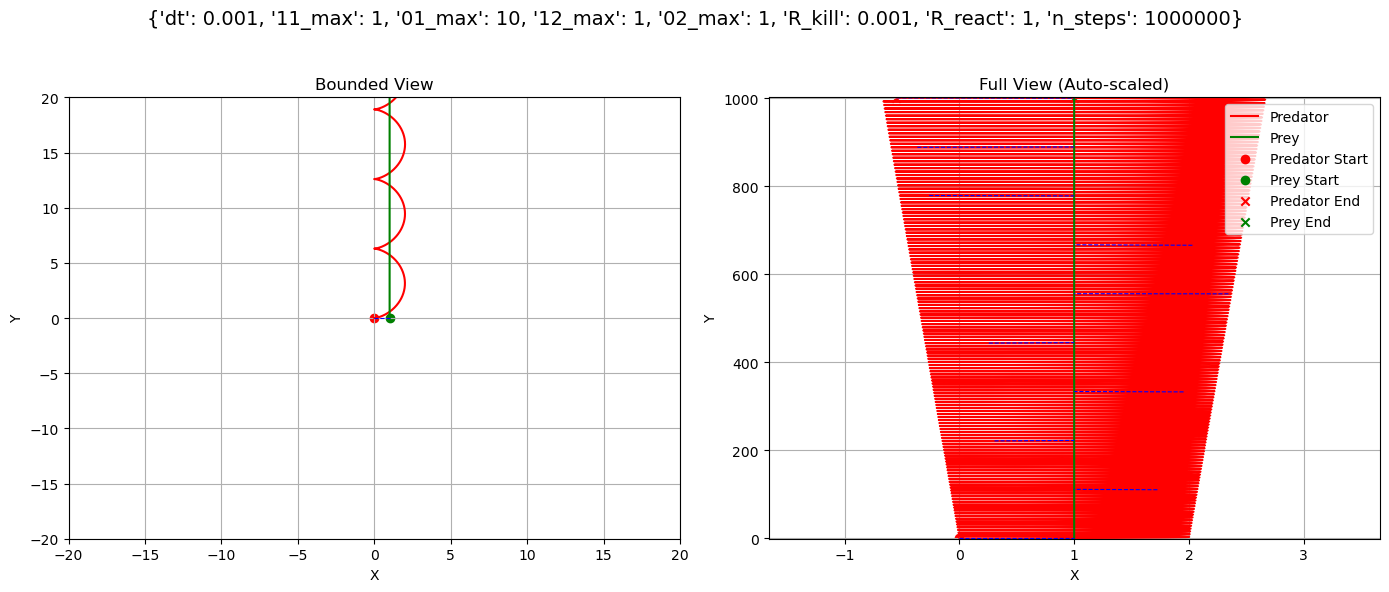

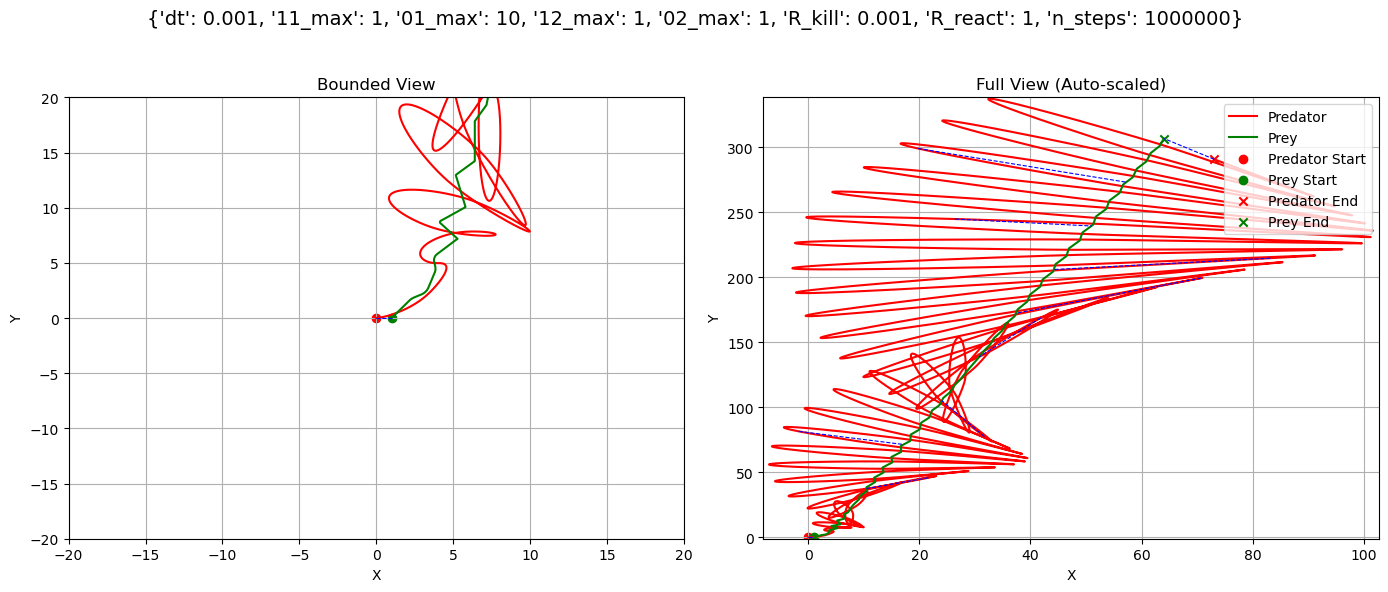

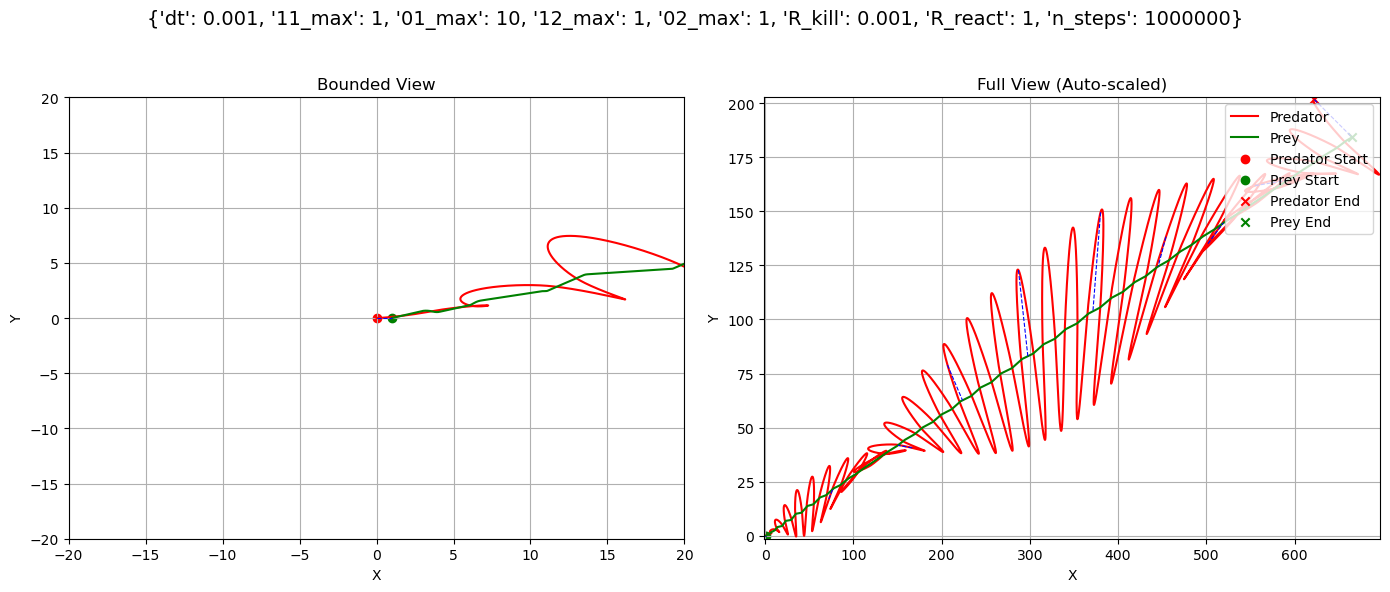

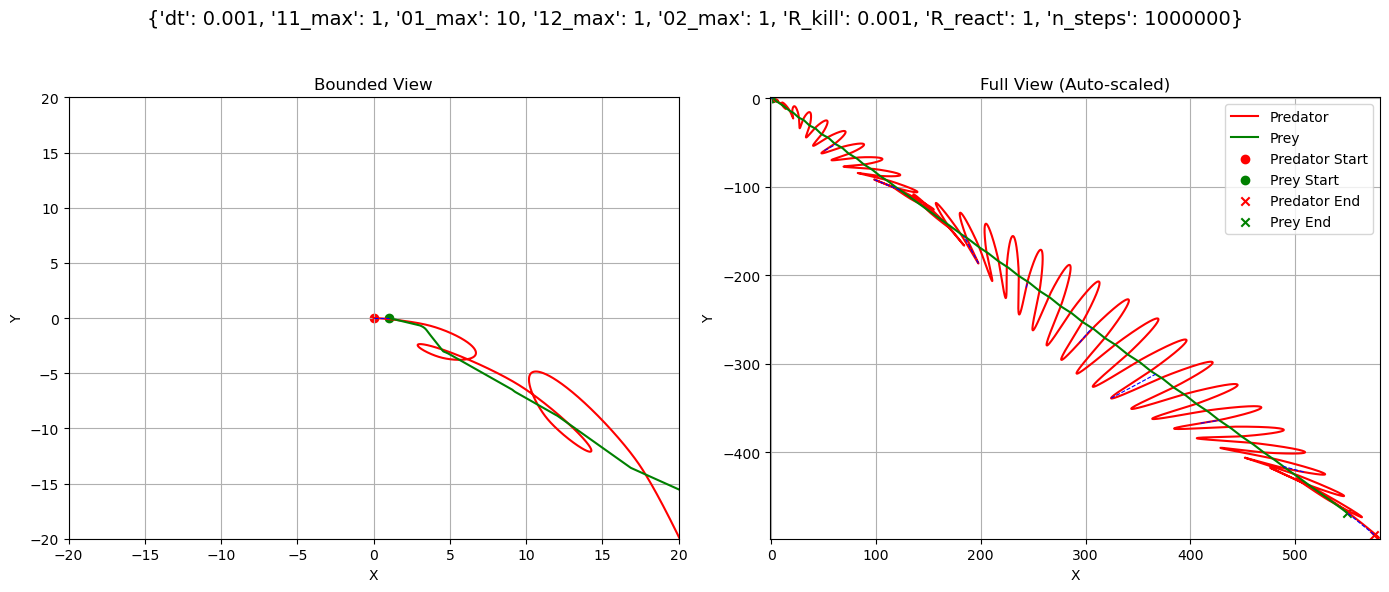

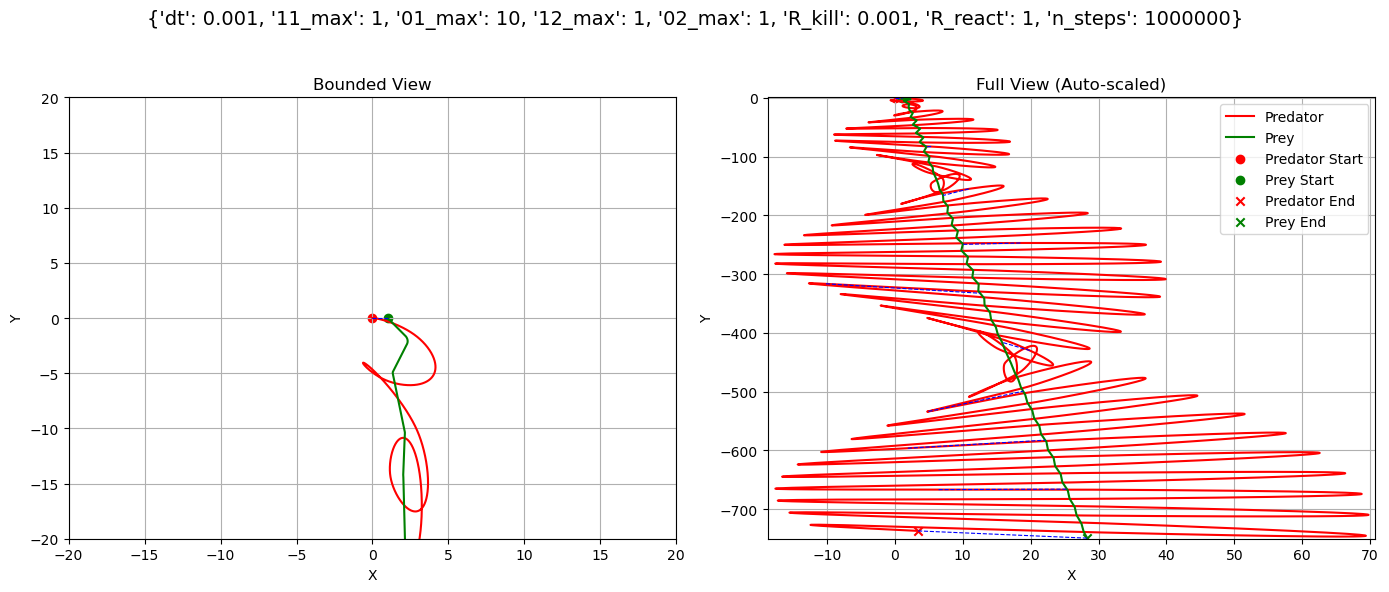

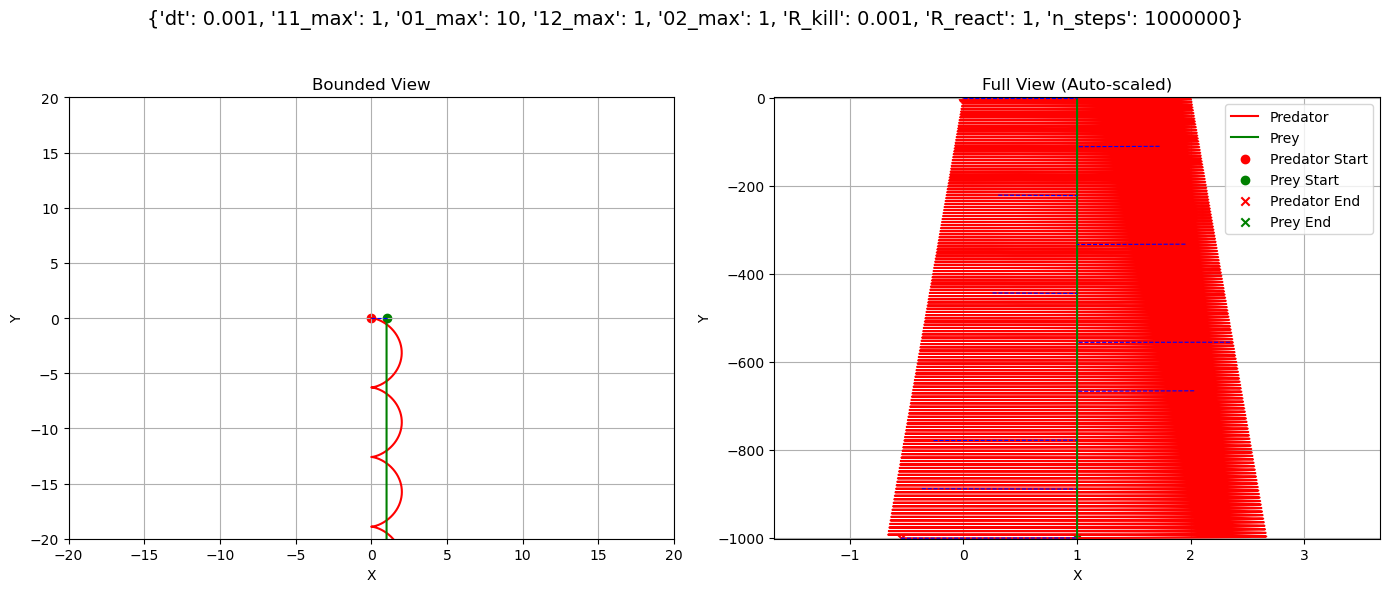

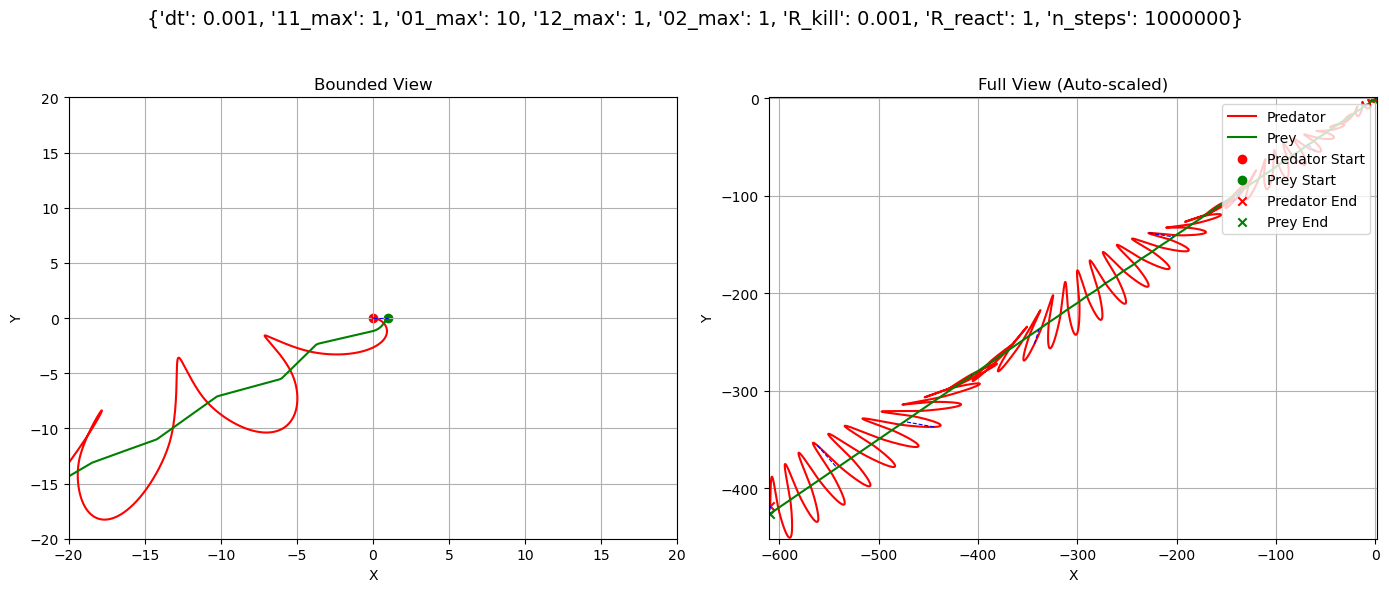

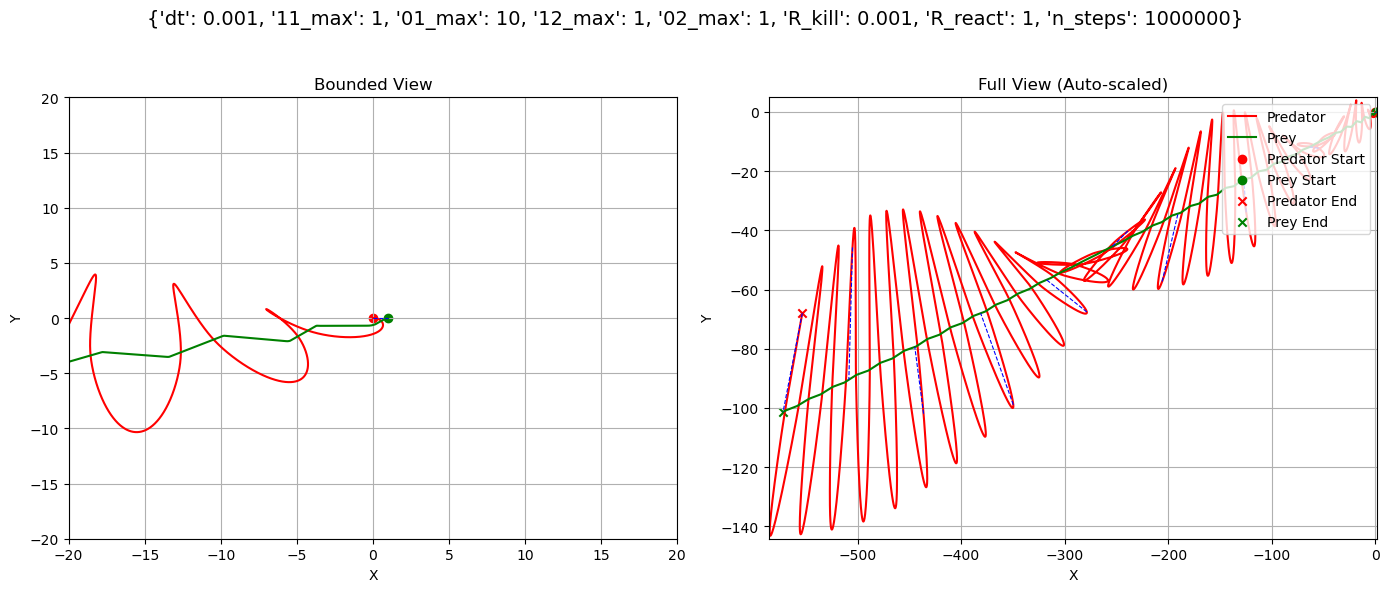

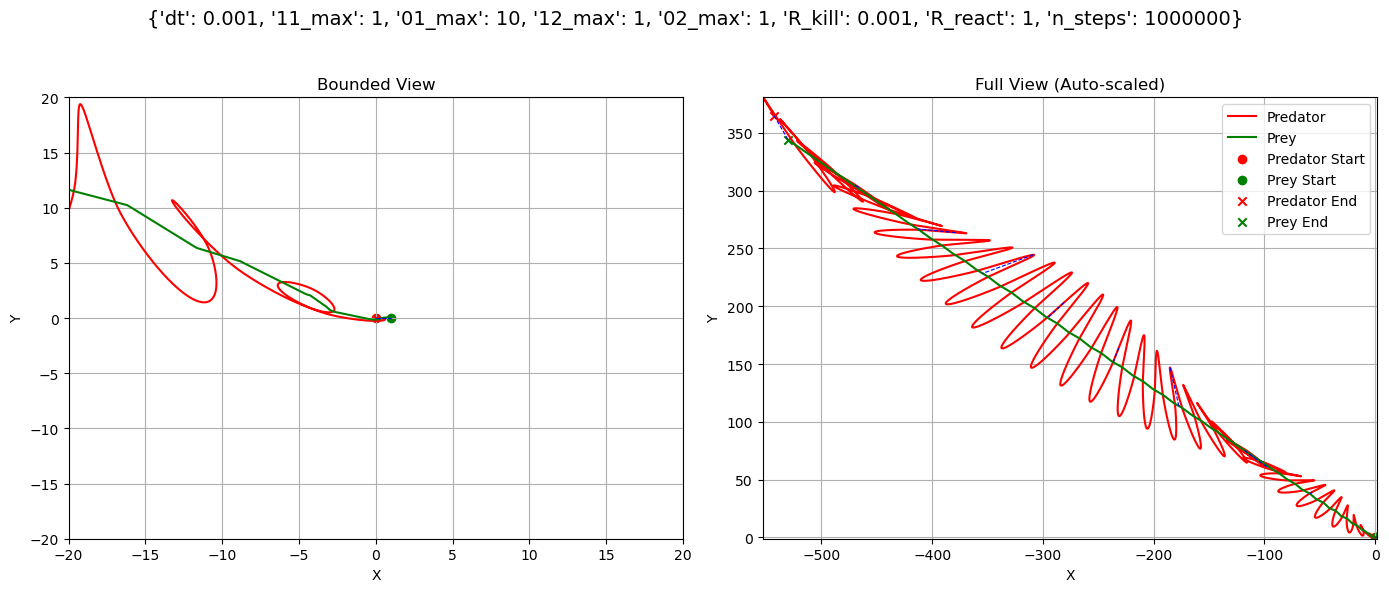

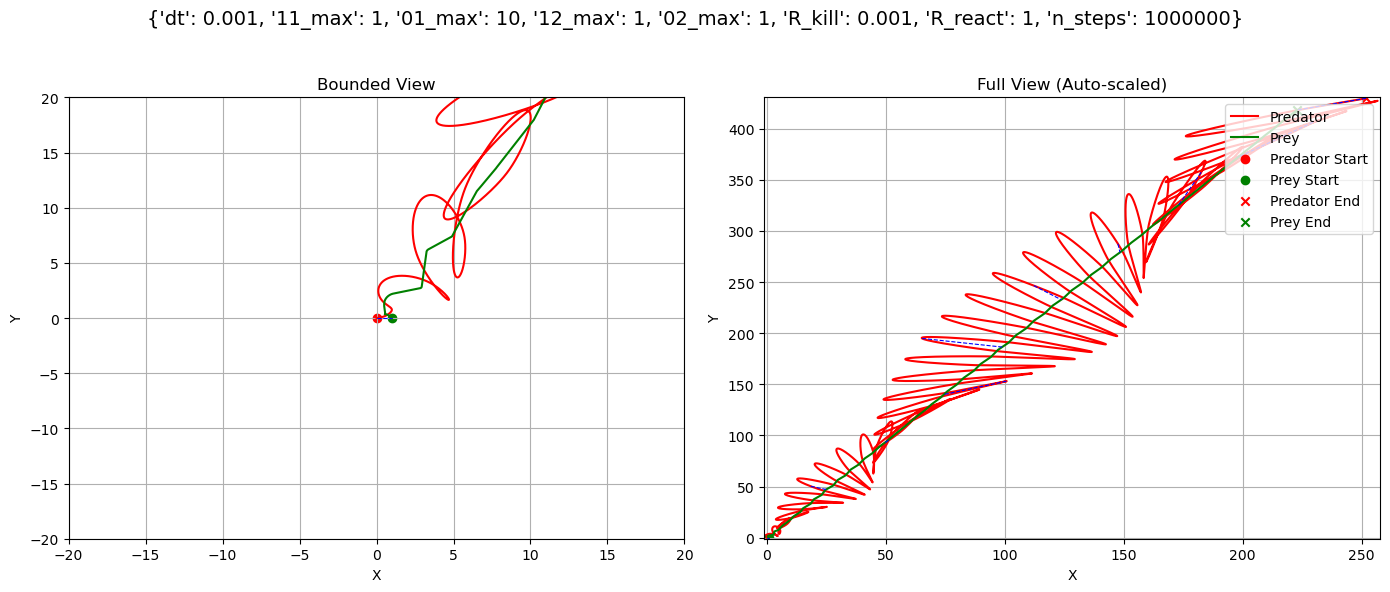

In [116]:
recordings = []
n = 10
for i in range(n):
    params = {
        "dt": 0.001,
        
        "11_max": 1,
        "01_max": 10, # >
        
        "12_max": 1, # >
        "02_max": 1,
        
        "R_kill": 0.001,
        "R_react": 1,
    }

    params['n_steps'] = round(1000 / params['dt'])
    
    state = get_trajectory(360/n*i, params)
    simulate(state, params)
    recordings += [(params, state)]

    plot_trajectories(state, params)

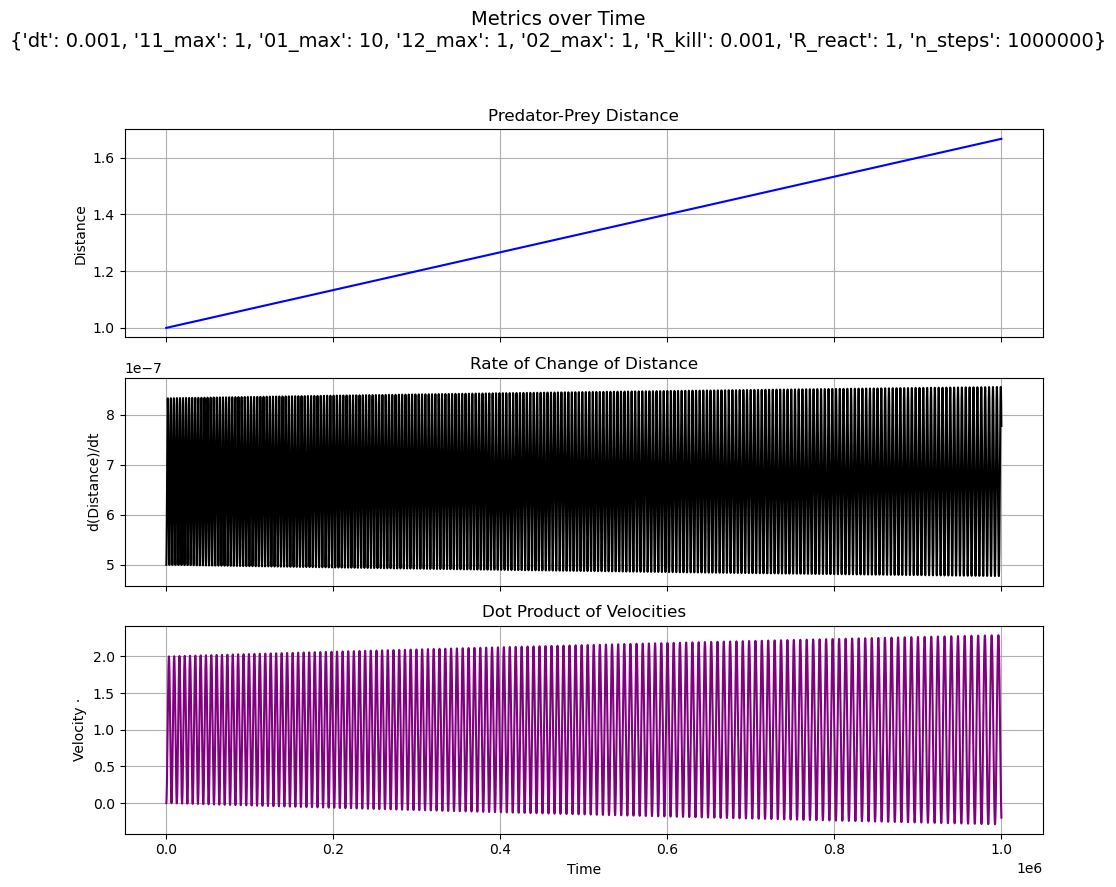

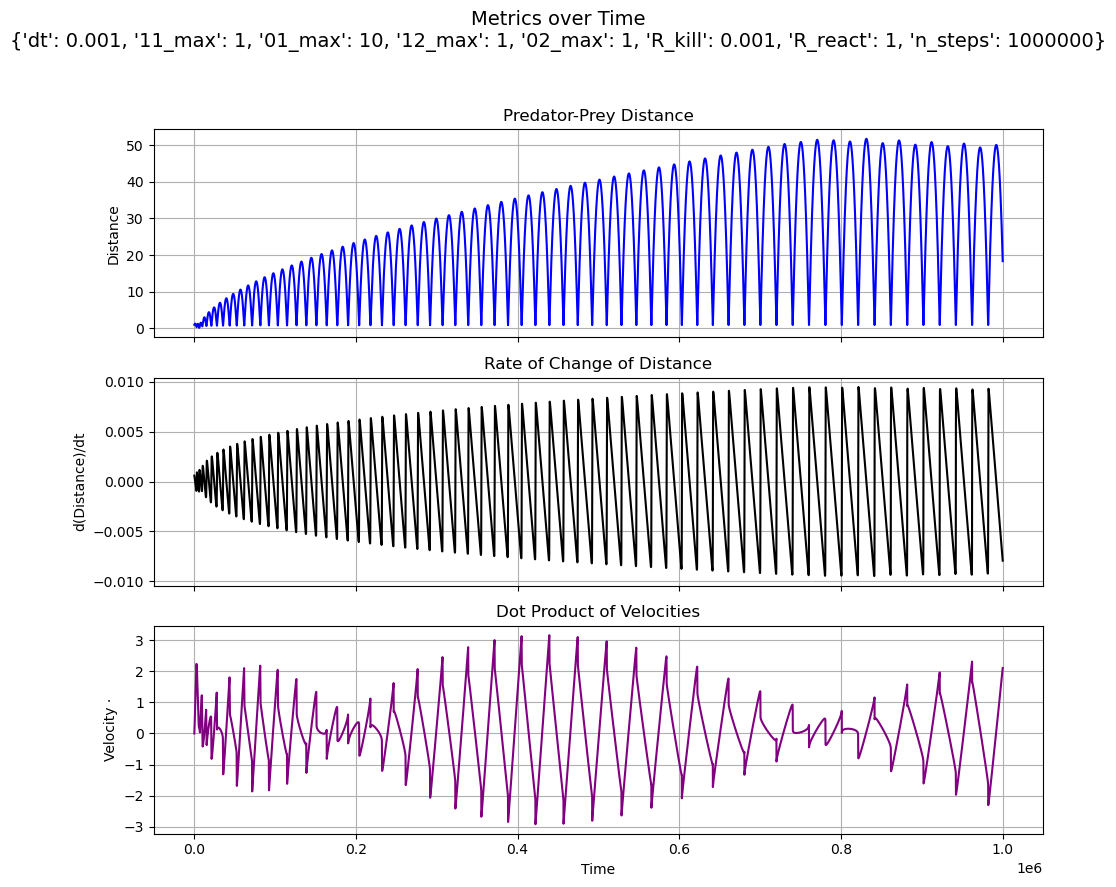

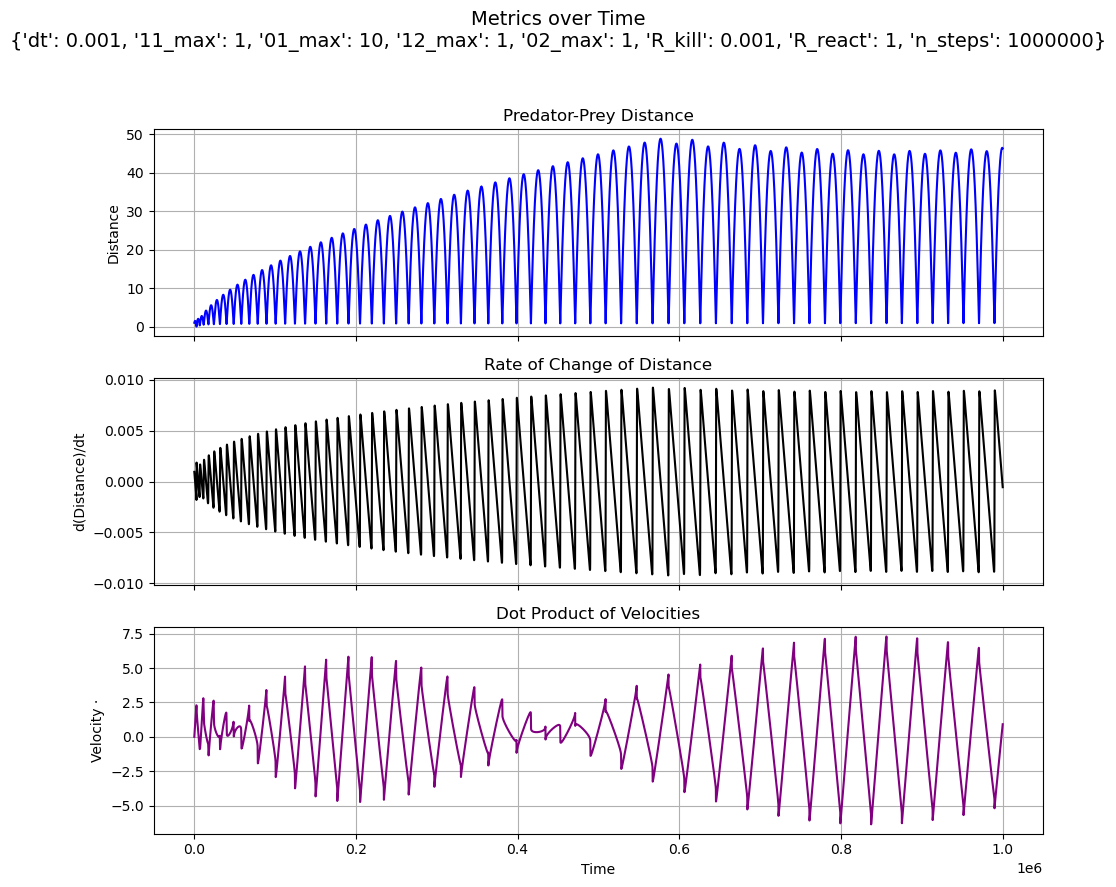

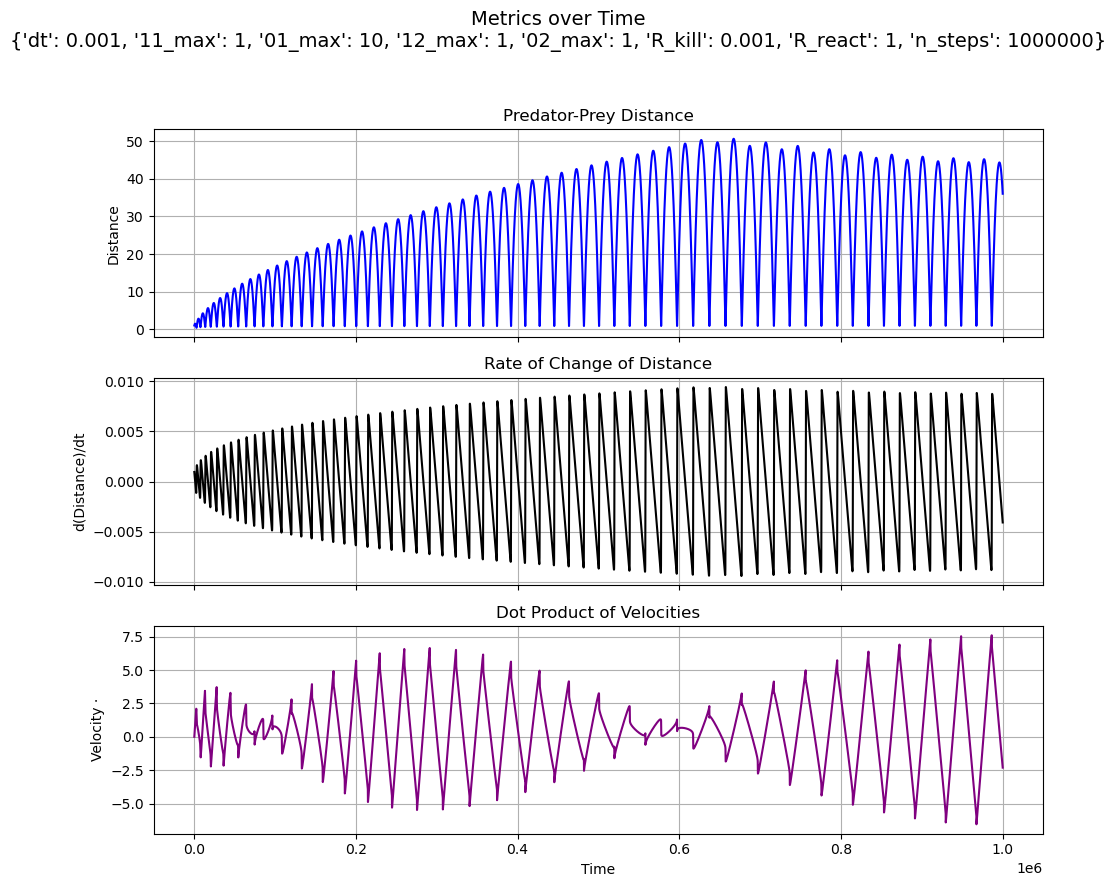

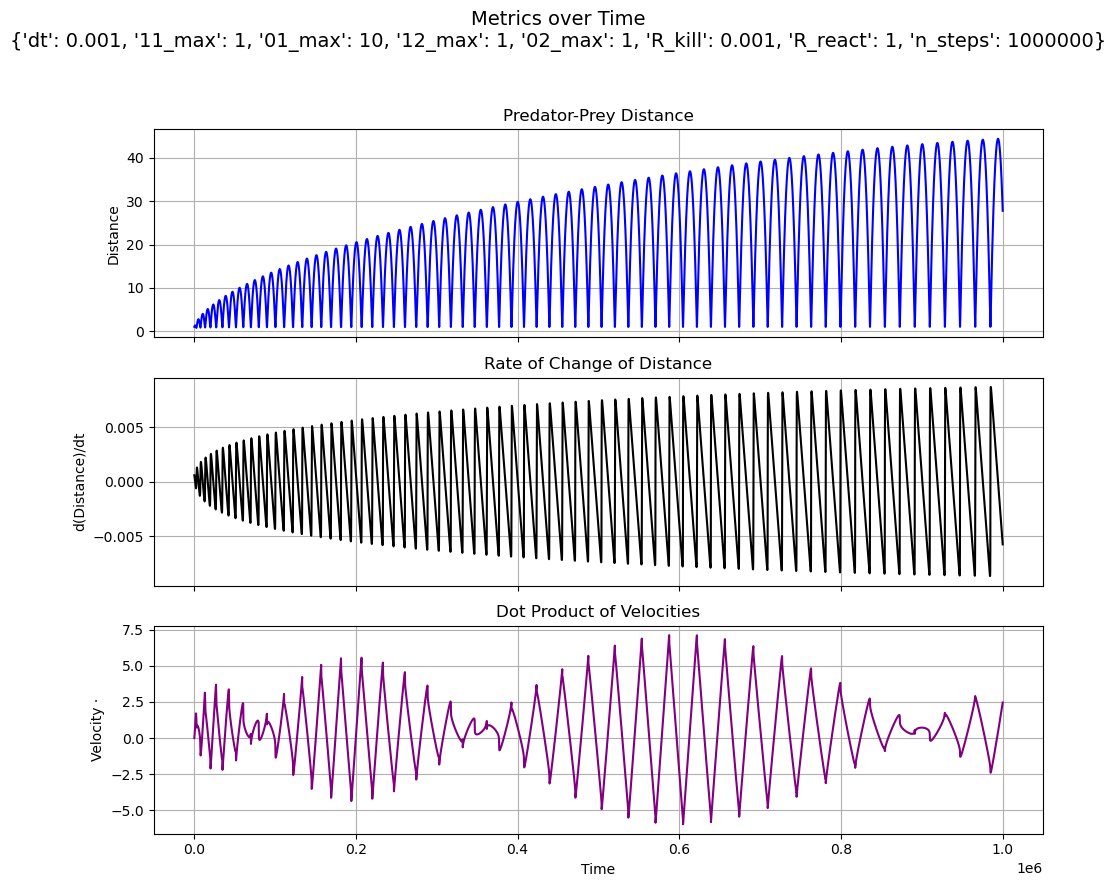

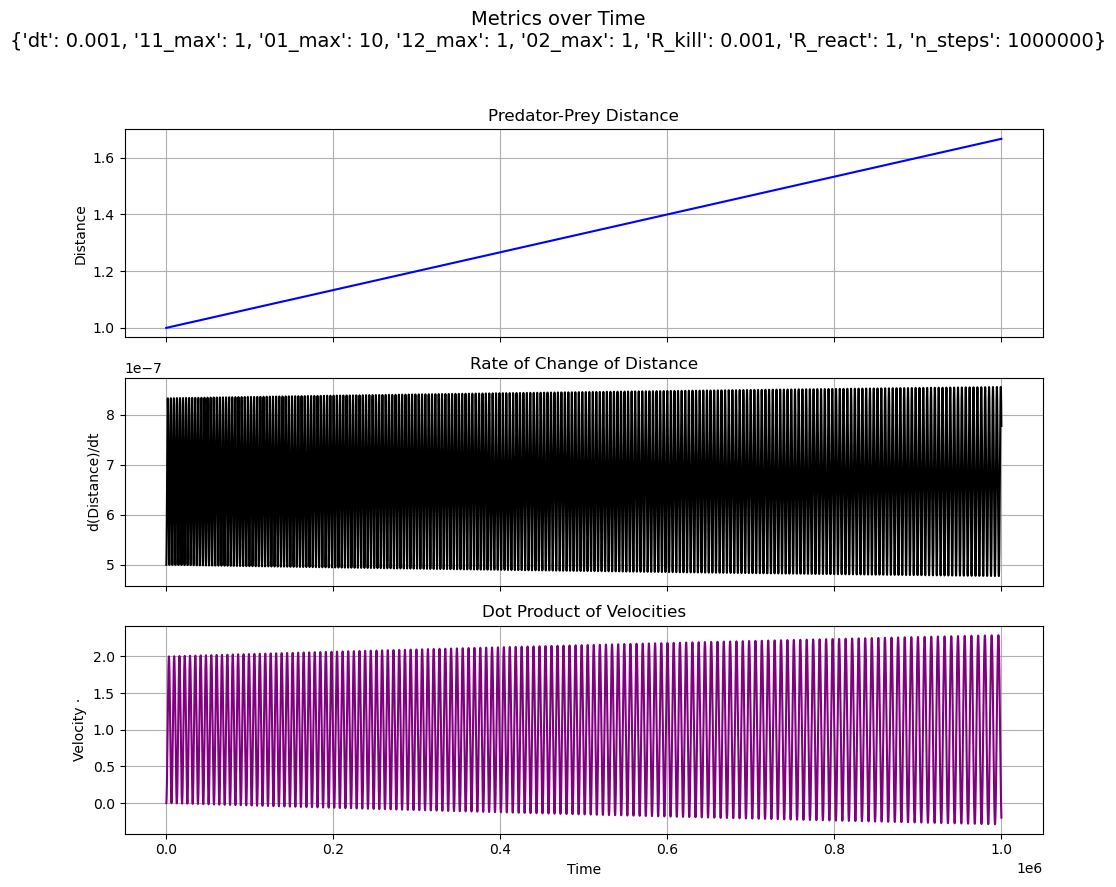

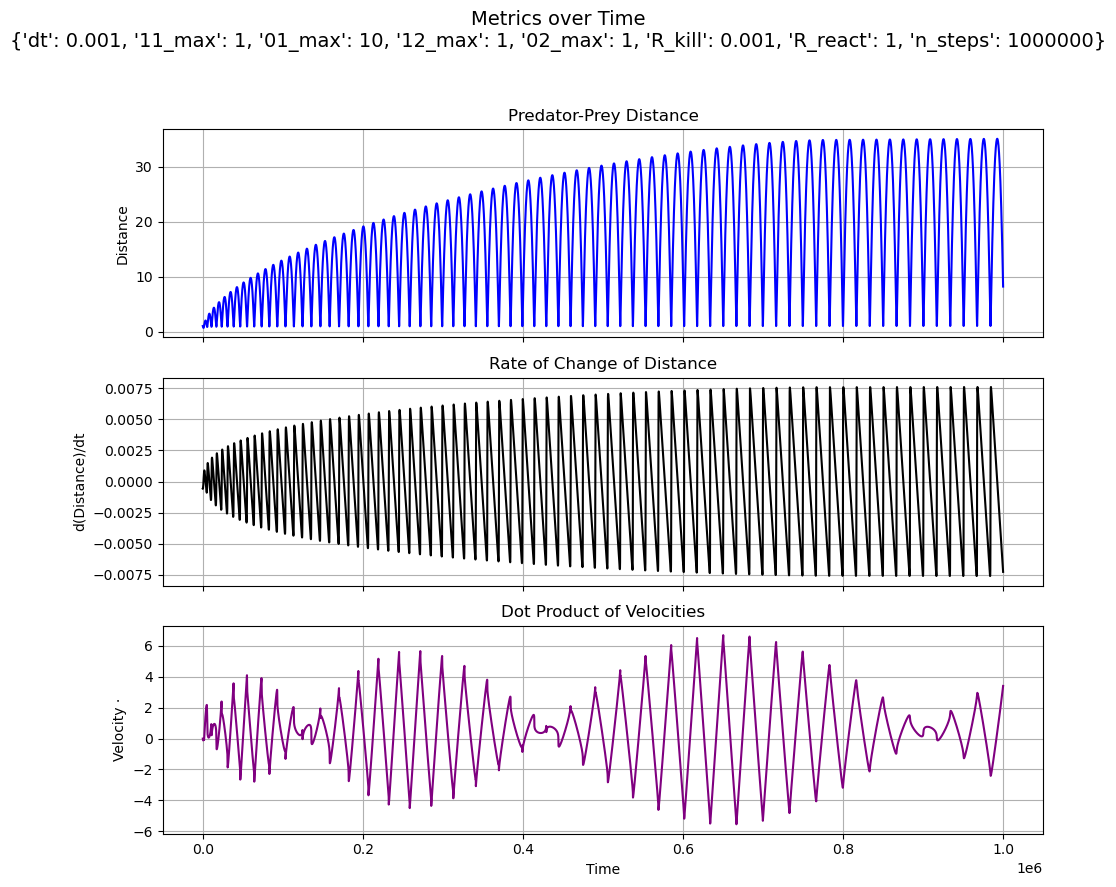

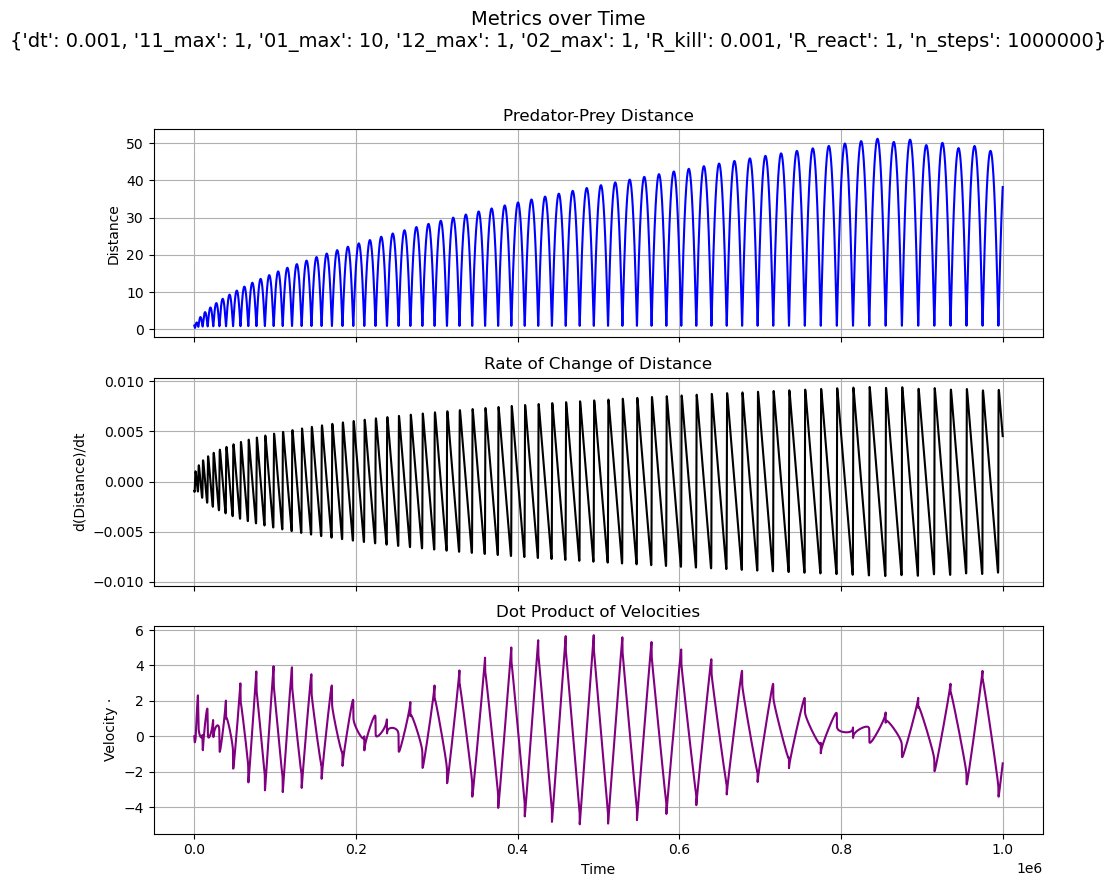

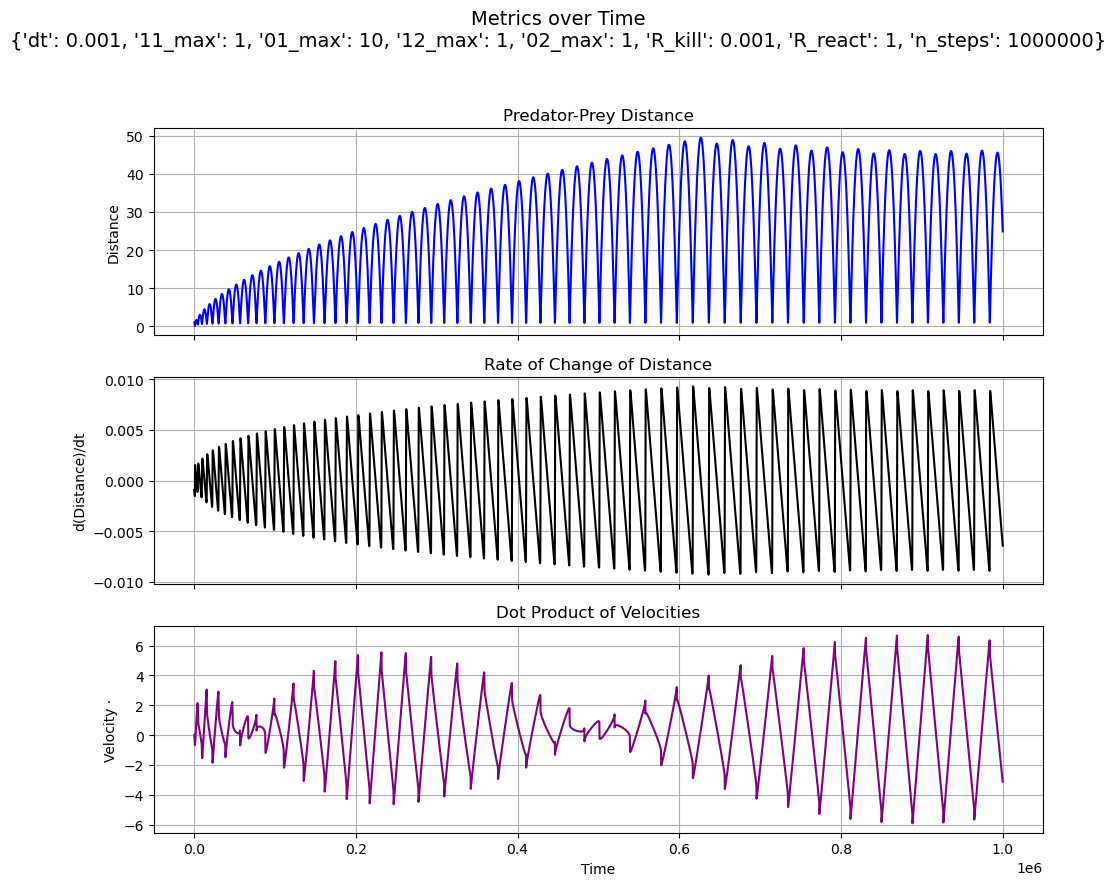

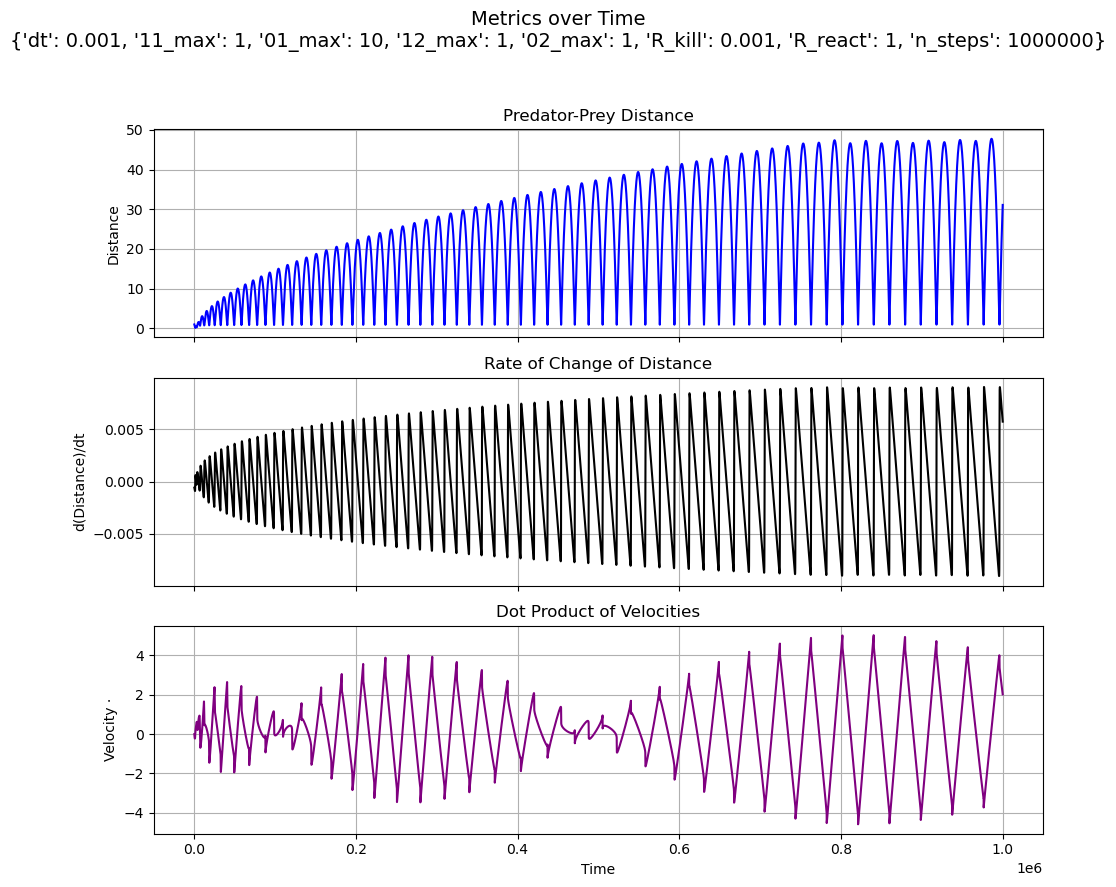

In [120]:
def plot_metrics(state, params: dict):
    """
    Plots three metrics over time:
    1. Distance between predator and prey (norm of position difference)
    2. Approximate derivative of that distance
    3. Dot product of predator and prey velocities
    """
    predator_pos = state[:, 0, 0, :]
    prey_pos = state[:, 1, 0, :]

    predator_vel = state[:, 0, 1, :]
    prey_vel = state[:, 1, 1, :]

    time = np.arange(state.shape[0])

    # 1. Distance
    distance = np.linalg.norm(predator_pos - prey_pos, axis=1)

    # 2. Derivative of distance (finite differences)
    distance_derivative = np.gradient(distance)

    # 3. Dot product of velocities
    velocity_dot = np.einsum('ij,ij->i', predator_vel, prey_vel)

    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
    fig.suptitle(f'Metrics over Time\n{params}', fontsize=14)

    # Distance
    axes[0].plot(time, distance, color='blue')
    axes[0].set_ylabel('Distance')
    axes[0].set_title('Predator-Prey Distance')
    axes[0].grid(True)

    # Derivative of distance
    axes[1].plot(time, distance_derivative, color='black')
    axes[1].set_ylabel('d(Distance)/dt')
    axes[1].set_title('Rate of Change of Distance')
    axes[1].grid(True)

    # Velocity dot product
    axes[2].plot(time, velocity_dot, color='purple')
    axes[2].set_ylabel('Velocity ⋅')
    axes[2].set_xlabel('Time')
    axes[2].set_title('Dot Product of Velocities')
    axes[2].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()    
    
for (param, state) in recordings:
    plot_metrics(state, param)

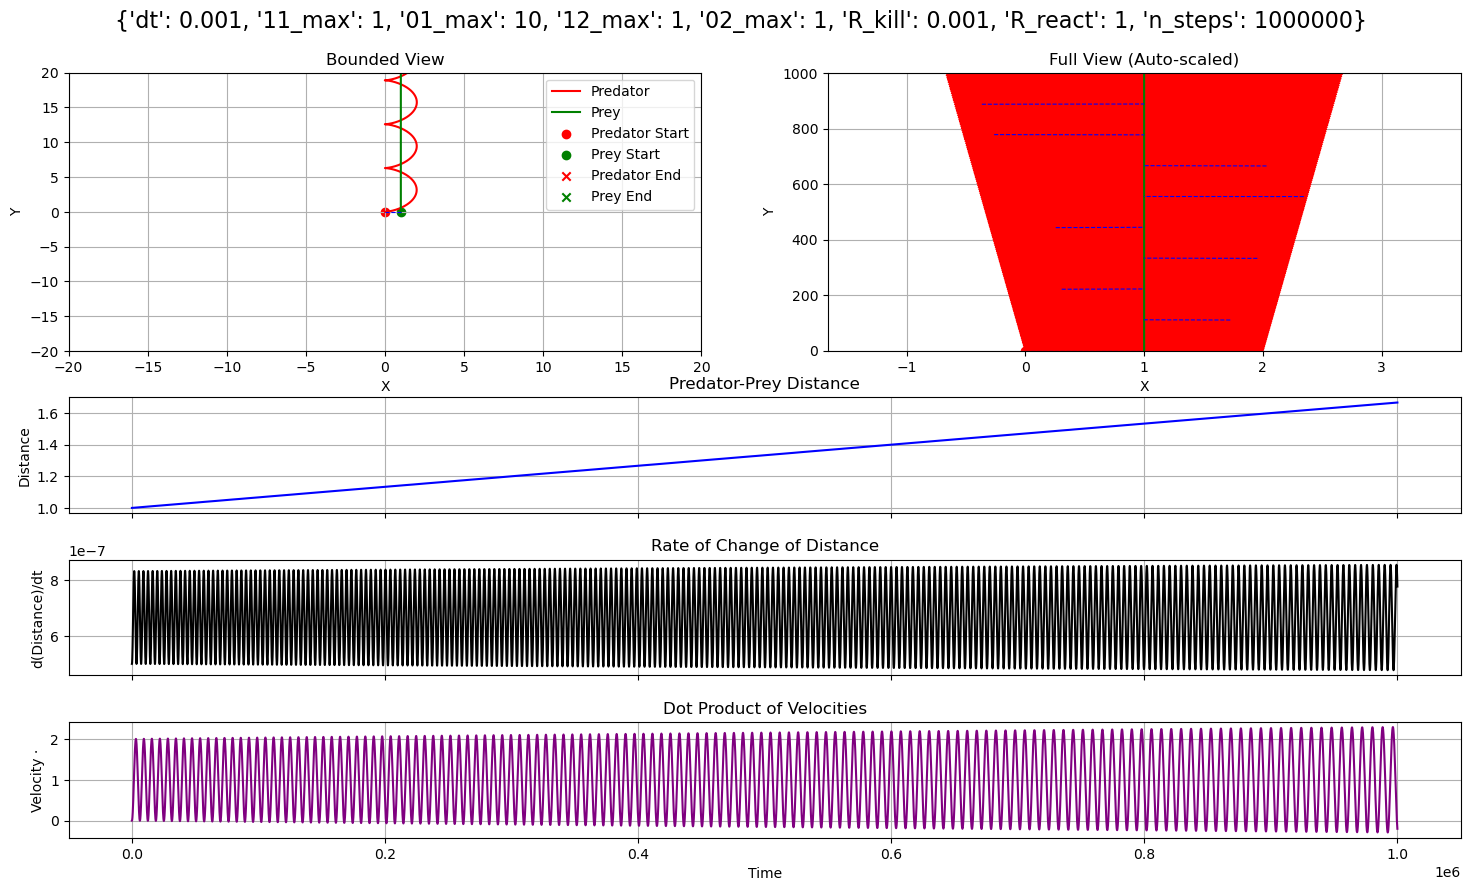

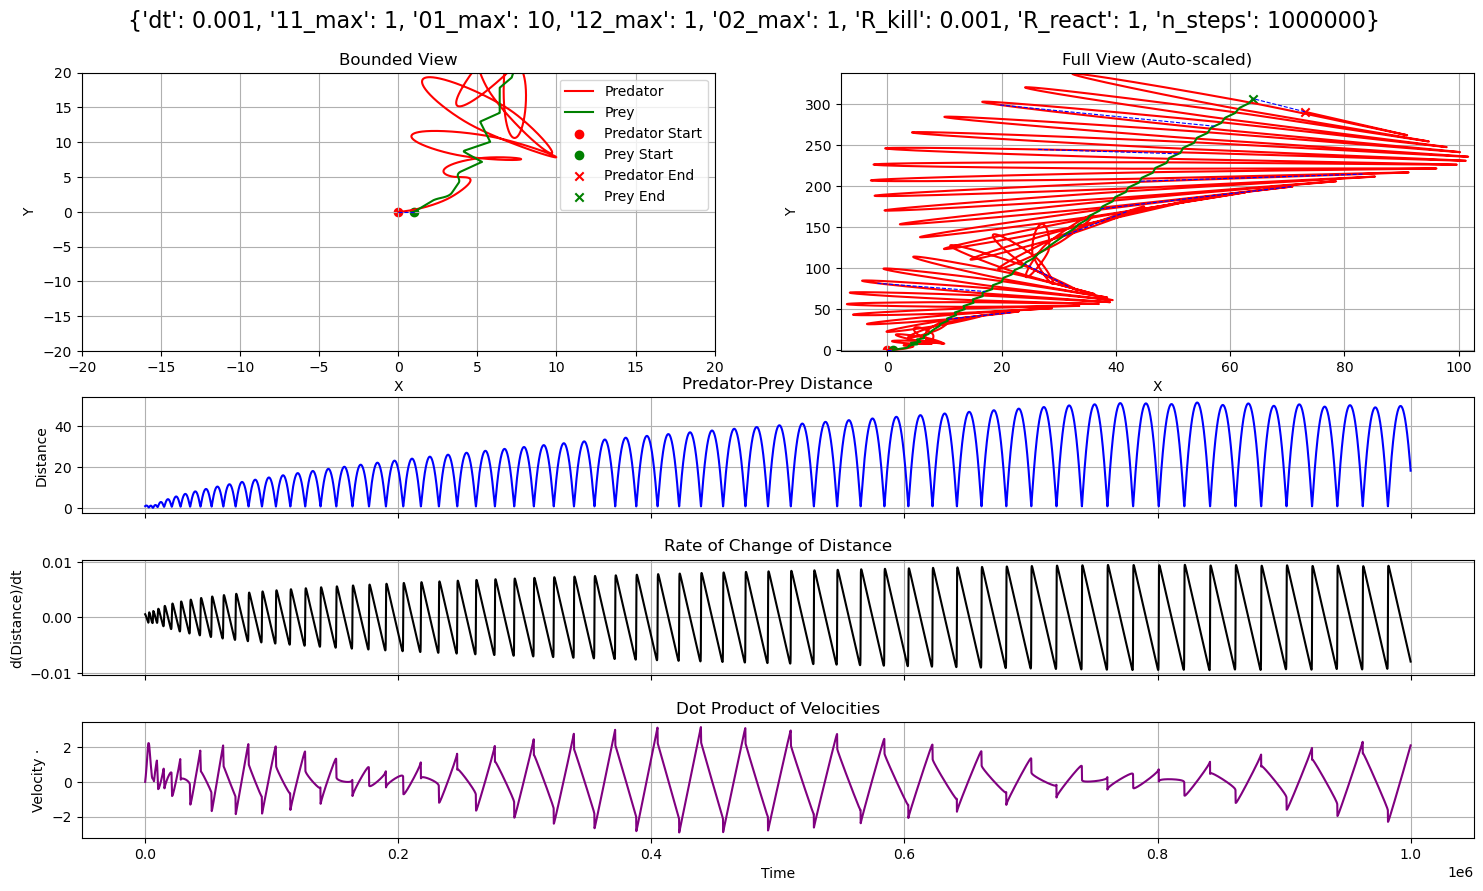

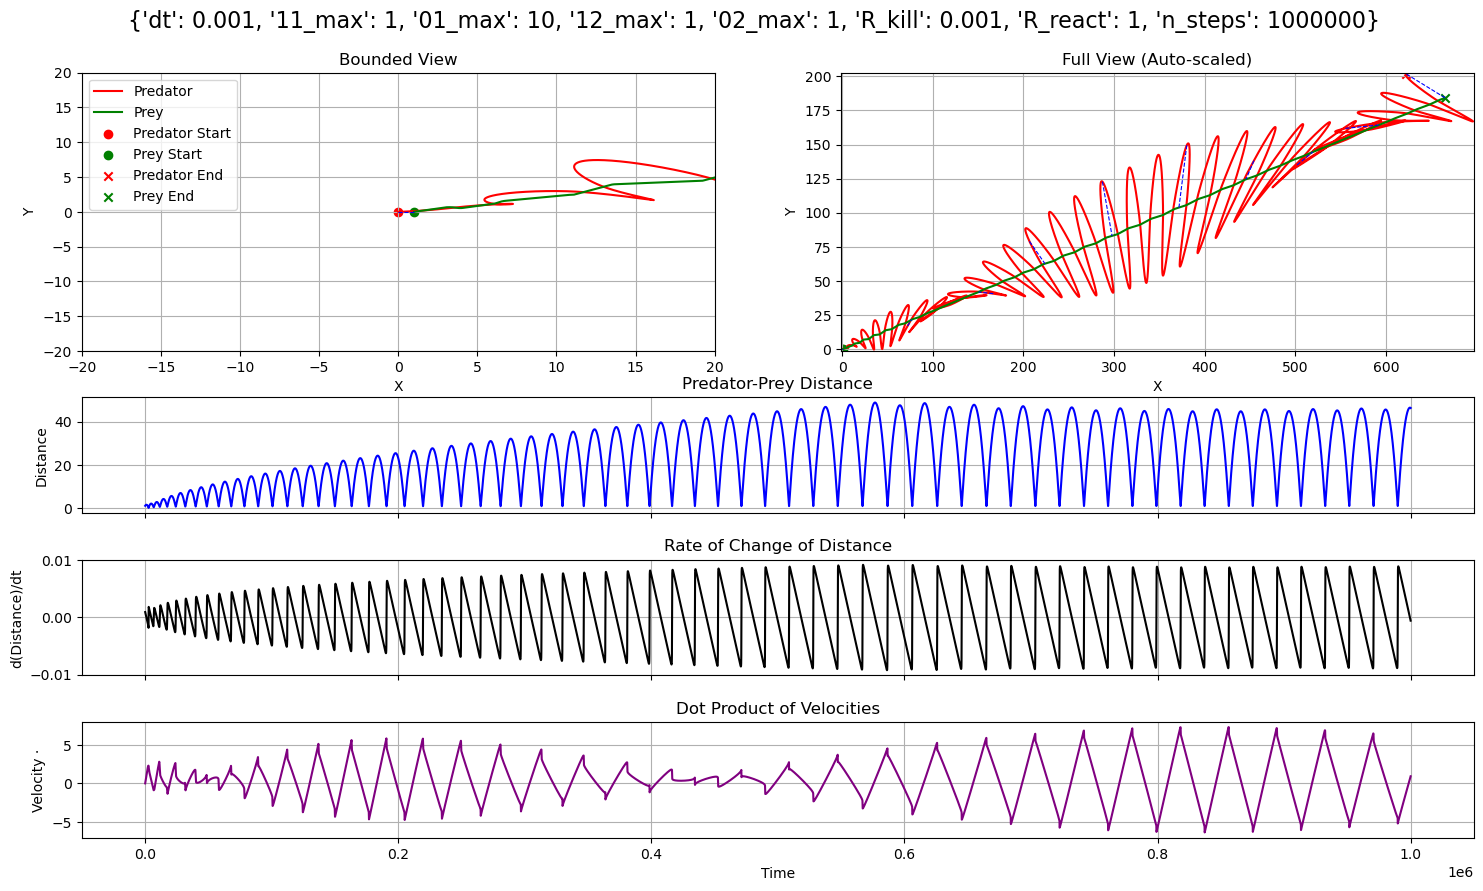

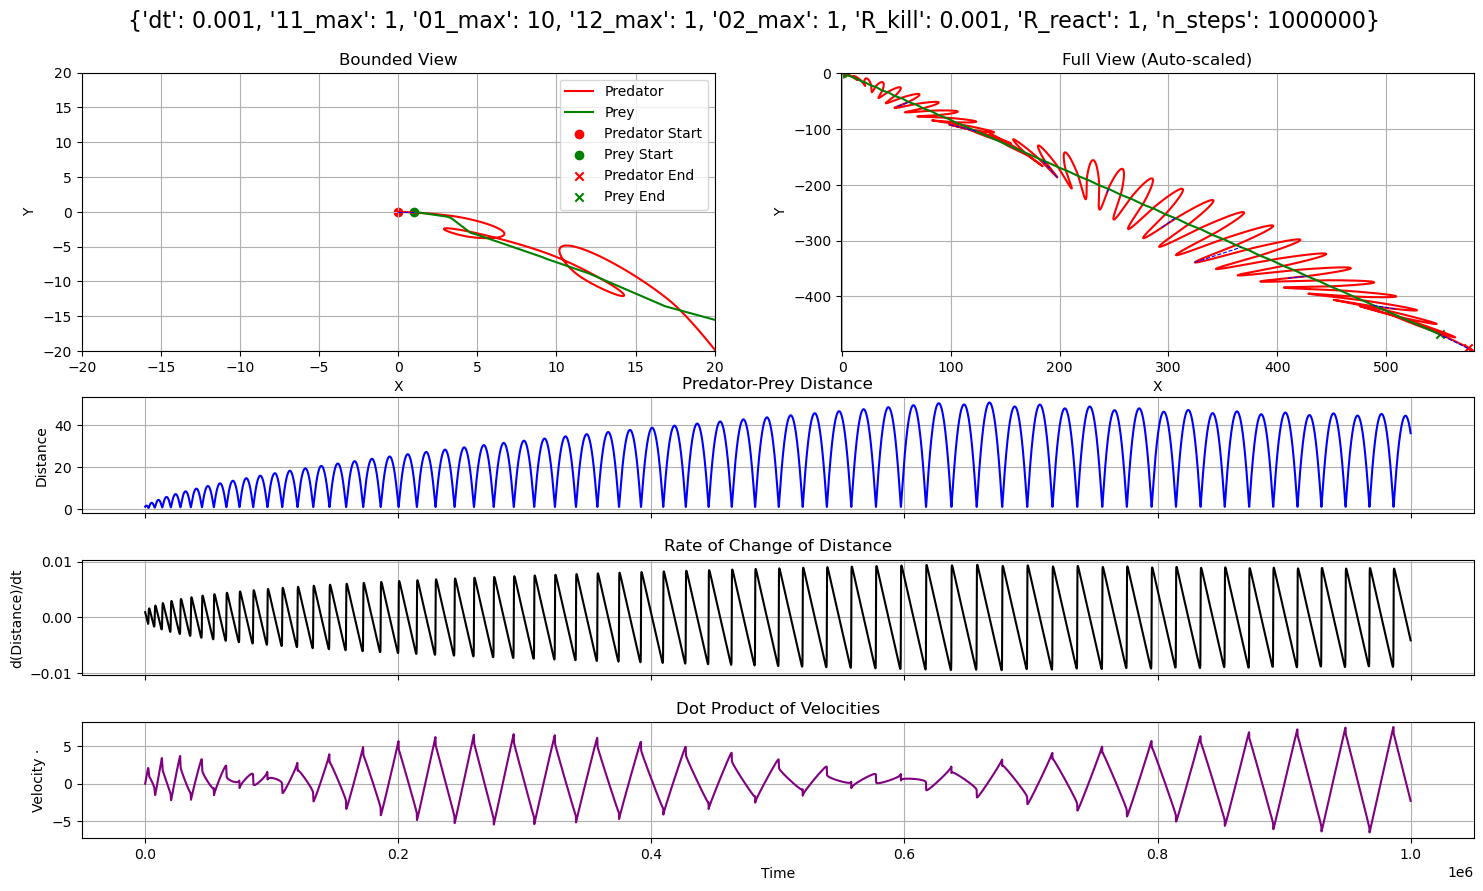

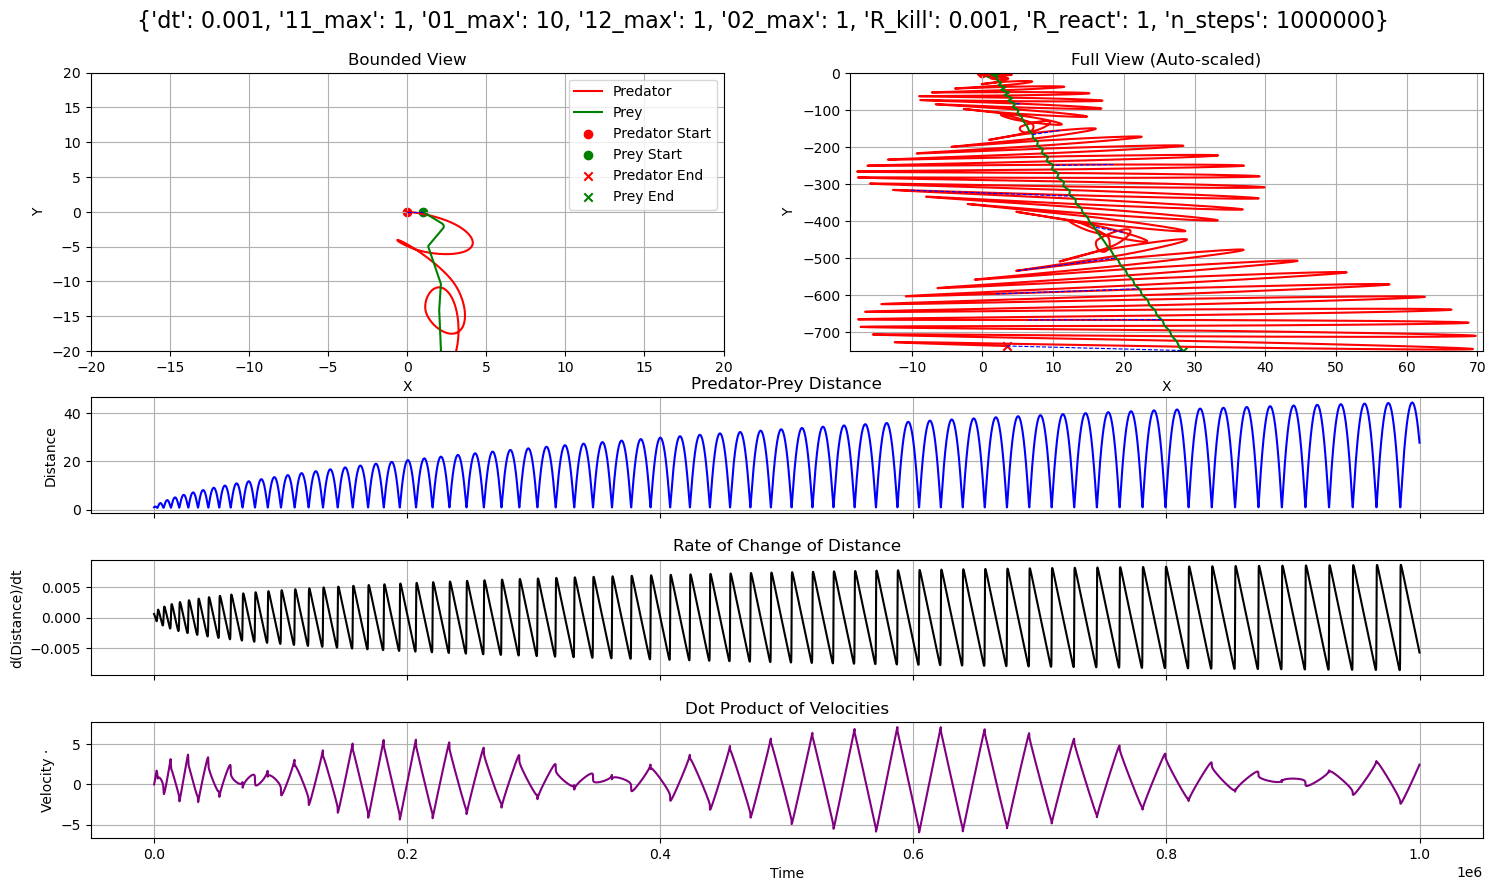

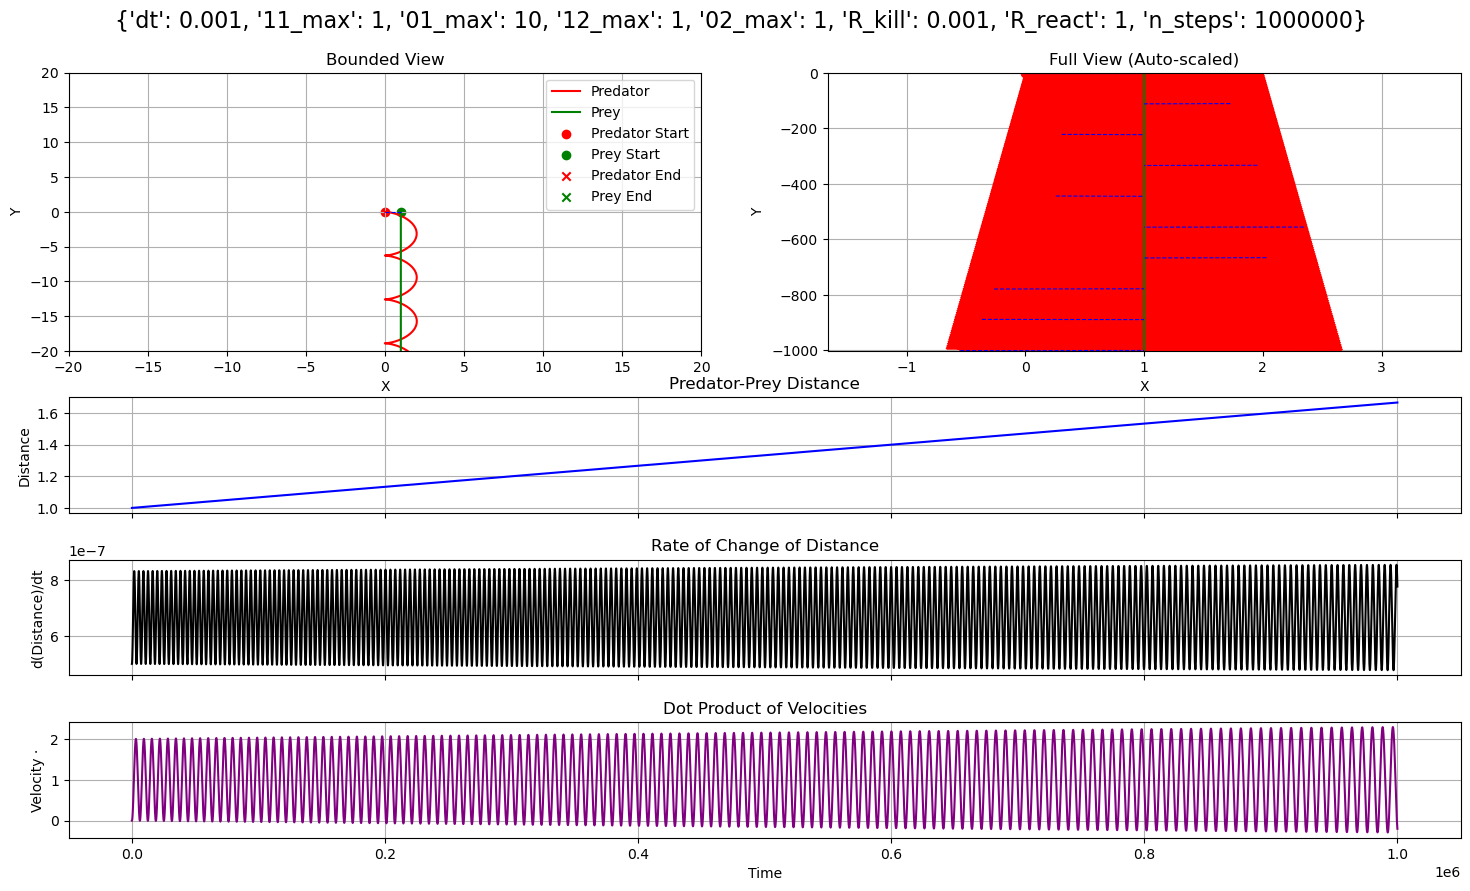

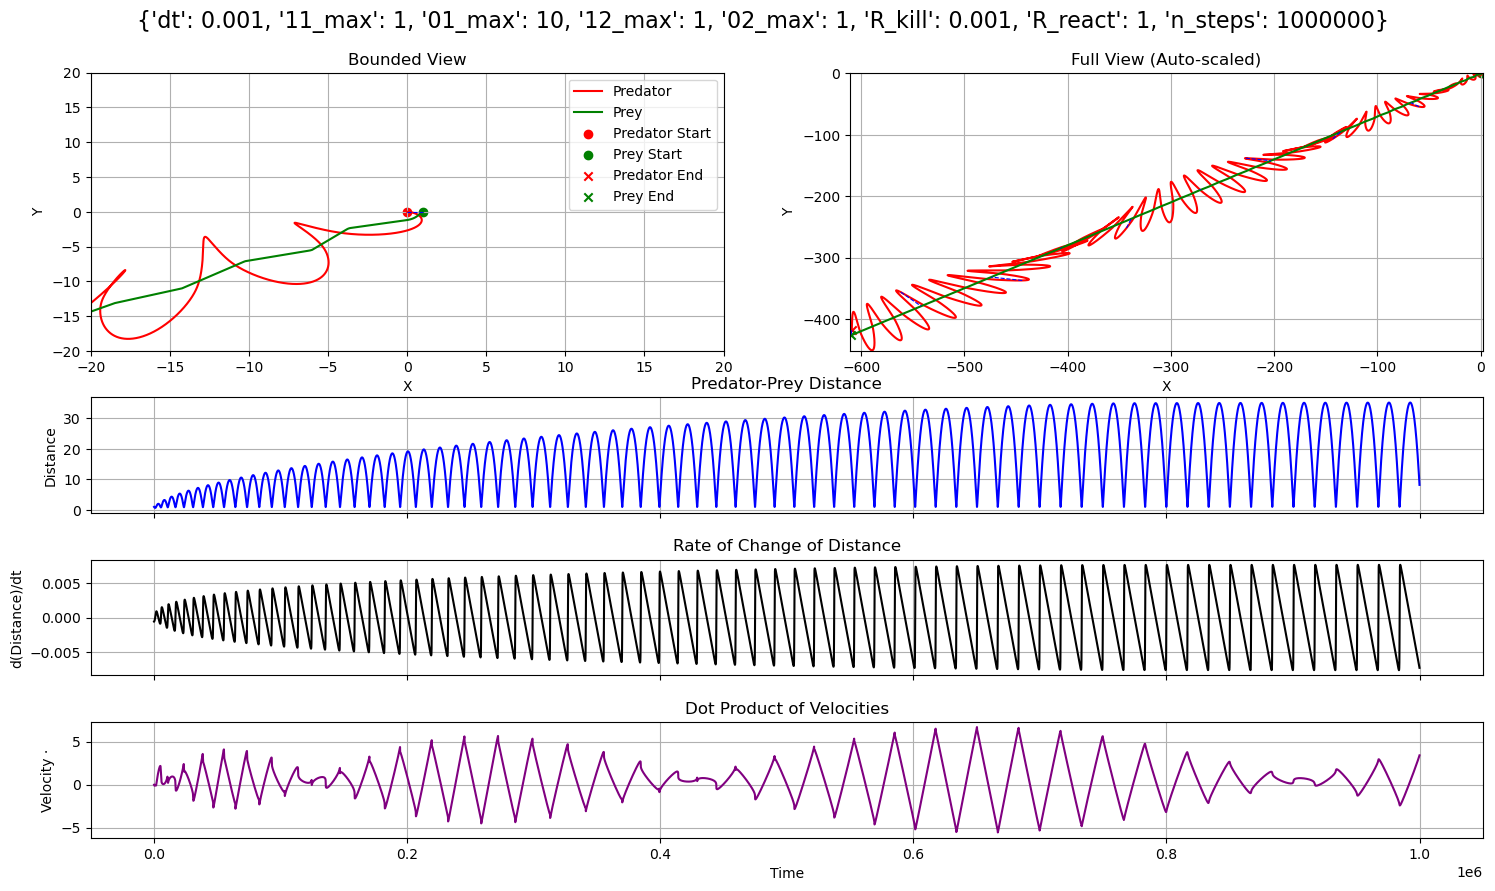

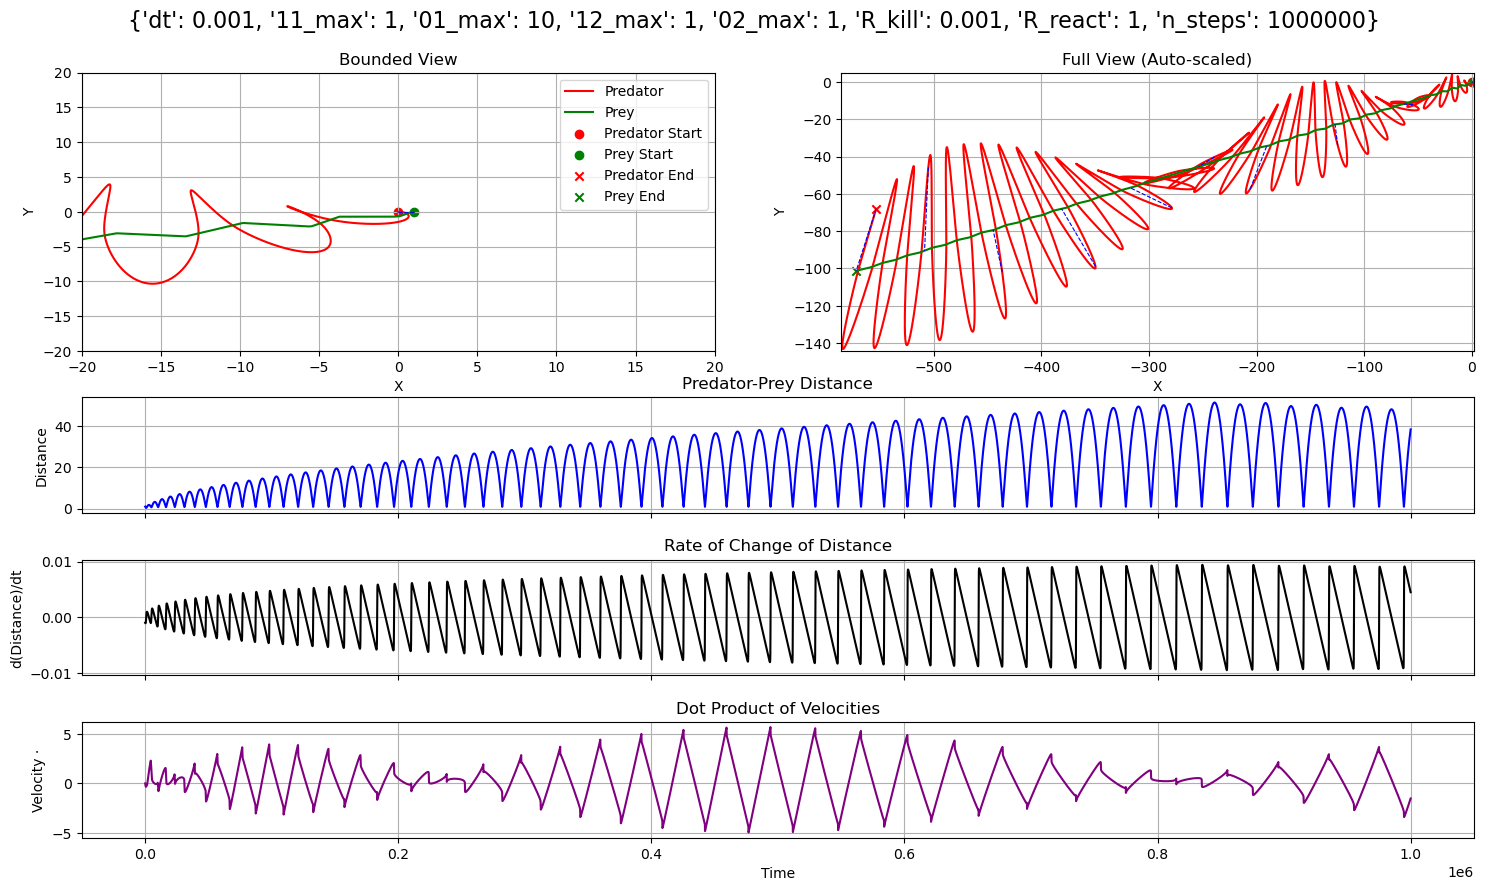

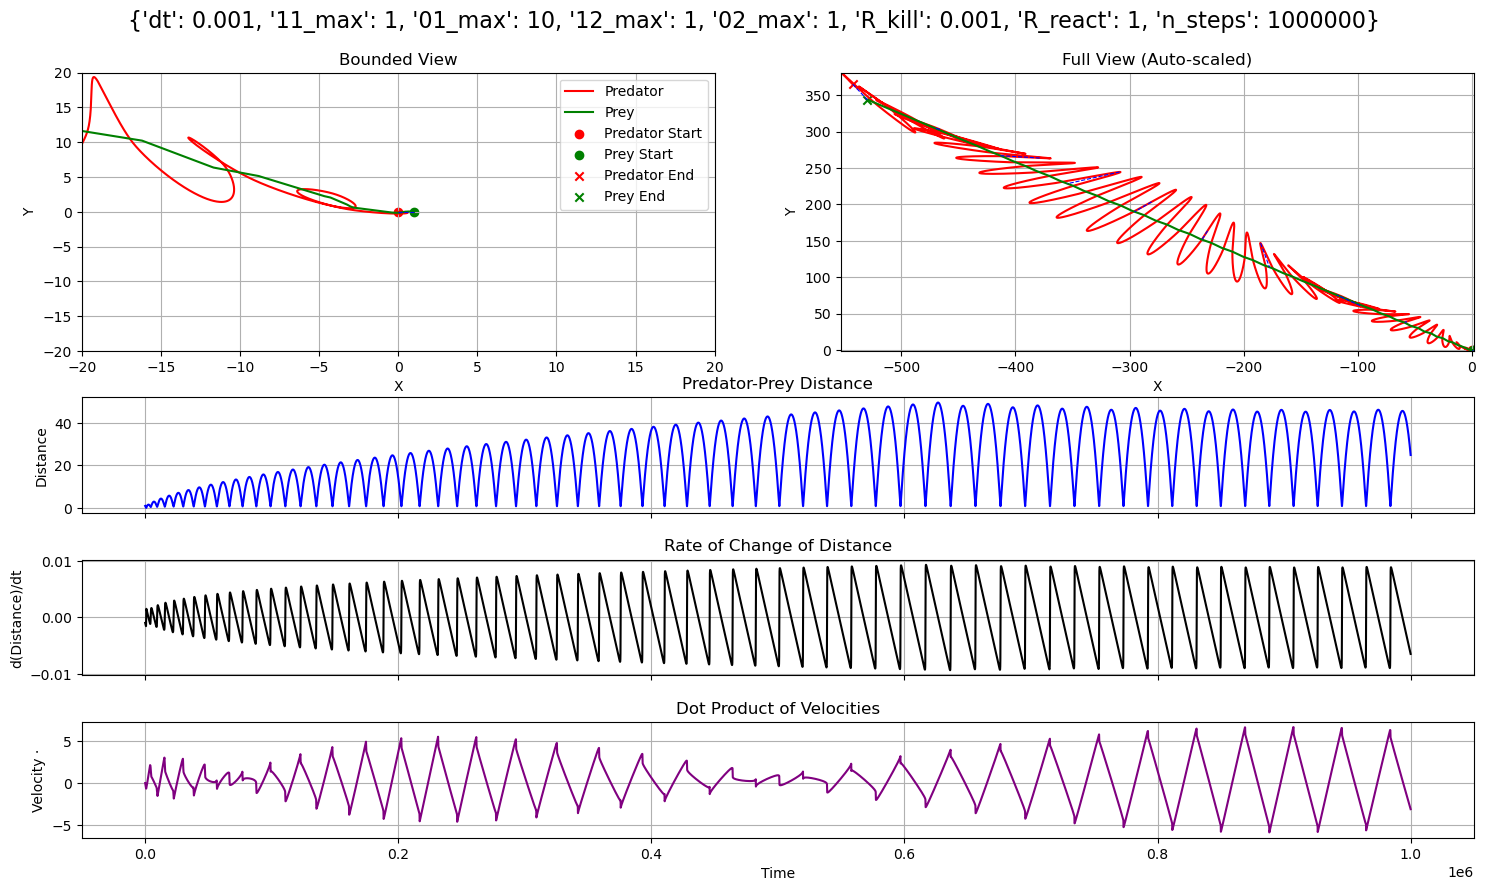

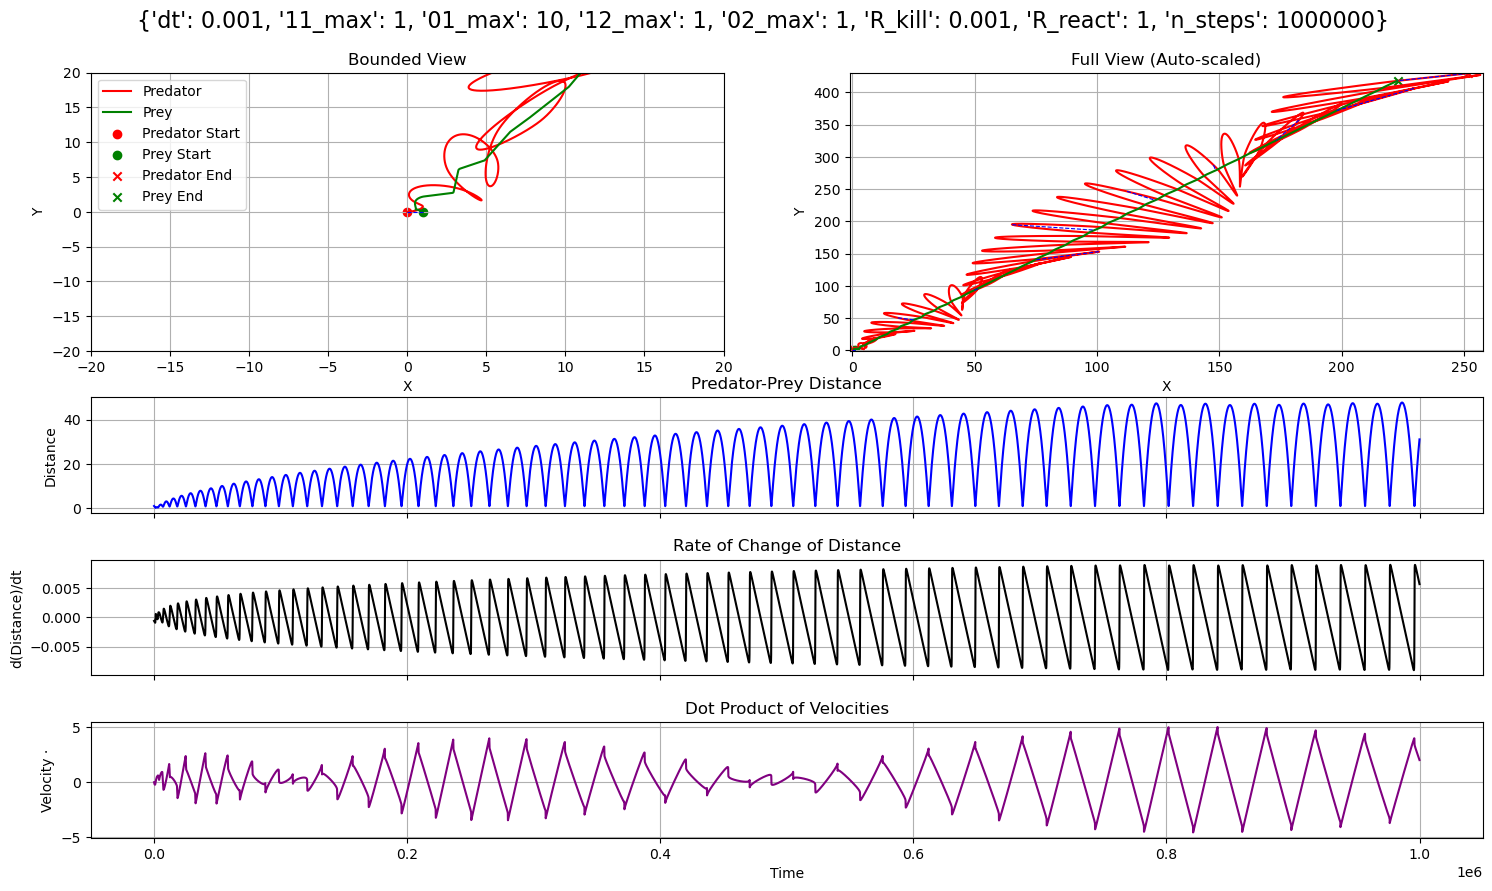

In [130]:
def plot_combined_analysis(state, params: dict, bound: int = 20, title=''):
    """
    Combined plotting function that shows:
    - Top row: Two trajectory plots side by side (bounded and auto-scaled)
    - Bottom section: Three metrics plots stacked vertically
    
    Parameters:
    - state: Simulation state array
    - params: Dictionary of simulation parameters
    - bound: Boundary for the fixed-scale trajectory plot
    - title: Optional custom title
    """
    state = state.copy()
    
    # Extract data for trajectory plots
    predator_pos = state[:, 0, 0, :]
    prey_pos = state[:, 1, 0, :]
    predator_vel = state[:, 0, 1, :]
    prey_vel = state[:, 1, 1, :]
    time = np.arange(state.shape[0])
    
    # Prepare connecting line indices for trajectory plots
    n_steps = state.shape[0]
    indices = np.linspace(0, n_steps - 1, 10, dtype=int)
    
    # Calculate metrics for the bottom plots
    # 1. Distance
    distance = np.linalg.norm(predator_pos - prey_pos, axis=1)
    # 2. Derivative of distance (finite differences)
    distance_derivative = np.gradient(distance)
    # 3. Dot product of velocities
    velocity_dot = np.einsum('ij,ij->i', predator_vel, prey_vel)
    
    # Create figure with customized layout
    fig = plt.figure(figsize=(16, 9))
    
    # Set the overall title with positioned farther from top
    if title == '':
        title = f'{params}'
    fig.suptitle(title, fontsize=16, y=0.99, va='top')
    
    # Create subplot layout with more explicit control
    # Trajectories (top row)
    ax_bounded = plt.subplot2grid((5, 2), (0, 0), rowspan=2)
    ax_autoscaled = plt.subplot2grid((5, 2), (0, 1), rowspan=2)
    
    # Metrics (bottom three rows)
    ax_distance = plt.subplot2grid((5, 2), (2, 0), colspan=2)
    ax_derivative = plt.subplot2grid((5, 2), (3, 0), colspan=2, sharex=ax_distance)
    ax_dot_product = plt.subplot2grid((5, 2), (4, 0), colspan=2, sharex=ax_distance)
    
    # Plot trajectories on the top two subplots
    for ax_idx, ax in enumerate([ax_bounded, ax_autoscaled]):
        ax.plot(predator_pos[:, 0], predator_pos[:, 1], label='Predator', color='red')
        ax.plot(prey_pos[:, 0], prey_pos[:, 1], label='Prey', color='green')
        ax.scatter(predator_pos[0, 0], predator_pos[0, 1], color='red', marker='o', label='Predator Start')
        ax.scatter(prey_pos[0, 0], prey_pos[0, 1], color='green', marker='o', label='Prey Start')
        ax.scatter(predator_pos[-1, 0], predator_pos[-1, 1], color='red', marker='x', label='Predator End')
        ax.scatter(prey_pos[-1, 0], prey_pos[-1, 1], color='green', marker='x', label='Prey End')
        
        for idx in indices:
            ax.plot(
                [predator_pos[idx, 0], prey_pos[idx, 0]],
                [predator_pos[idx, 1], prey_pos[idx, 1]],
                color='blue', linestyle='--', linewidth=0.8
            )
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.grid(True)
        
        if ax_idx == 0:
            ax.set_xlim(-bound, bound)
            ax.set_ylim(-bound, bound)
            ax.set_title('Bounded View')
            ax.legend(loc='best')
        elif ax_idx == 1:
            all_positions = np.vstack([predator_pos, prey_pos])
            x_min, y_min = np.min(all_positions, axis=0)
            x_max, y_max = np.max(all_positions, axis=0)
            ax.set_xlim(x_min - 1, x_max + 1)
            ax.set_ylim(y_min - 1, y_max + 1)
            ax.set_title('Full View (Auto-scaled)')
    
    # Plot metrics on the bottom three subplots
    # Distance
    ax_distance.plot(time, distance, color='blue')
    ax_distance.set_ylabel('Distance')
    ax_distance.set_title('Predator-Prey Distance')
    ax_distance.grid(True)
    ax_distance.label_outer()  # Hide x-tick labels
    
    # Derivative of distance
    ax_derivative.plot(time, distance_derivative, color='black')
    ax_derivative.set_ylabel('d(Distance)/dt')
    ax_derivative.set_title('Rate of Change of Distance')
    ax_derivative.grid(True)
    ax_derivative.label_outer()  # Hide x-tick labels
    
    # Velocity dot product
    ax_dot_product.plot(time, velocity_dot, color='purple')
    ax_dot_product.set_ylabel('Velocity ⋅')
    ax_dot_product.set_xlabel('Time')
    ax_dot_product.set_title('Dot Product of Velocities')
    ax_dot_product.grid(True)
    
    # Ensure proper spacing without using tight_layout
    fig.subplots_adjust(hspace=0.4, top=0.92, bottom=0.07, left=0.08, right=0.95)
    
    plt.show()
    return fig

    
for (param, state) in recordings:
    plot_combined_analysis(state, param)